# Urban Insight: Clustering Quality of Life and Cost of Living

**Names**: Aleksandra Grigortsuk, Wendy Zheng, Yinglei Wu, Xiangrui Deng

## 1. Introduction

When making global-scale decisions about several countries and/or cities, it is important to explore data about the quality of life and cost of living of cities, as well as thoroughly examine the subtle nuances that shape these urban environments. The dataset, extracted from movehub.com, contains metrics about the quality of life and cost of living for 198 cities. Clustering the dataset can help guide practical decisions about relocation and investment for individuals or organizations. By discovering patterns within the data, stakeholders can gain valuable insights that improve nuanced decision-making, ensuring a more informed approach to navigating the diverse landscape of global cities. For individuals, it allows them to making well-informed choices that align with their lifestyle preferences and financial considerations, leading to a smoother and more satisfying transition to a new living environment.


## 2. Dataset Discussion

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from gower import gower_matrix

from scipy.spatial.distance import pdist, squareform
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('movehub_data_cleaned.csv')
df.head(5)

City        Country  Cappuccino  Cinema   Wine  Gasoline  Avg Rent  \
0   Lausanne    Switzerland        3.15   12.59   8.40      1.32   1714.00   
1     Geneva    Switzerland        2.80   12.94  10.49      1.28   2607.95   
2      Basel    Switzerland        3.50   11.89   7.35      1.25   1649.29   
3      Perth      Australia        2.87   11.43  10.08      0.97   2083.14   
4  Nashville  United States        3.84   12.00  13.50      0.65   2257.14   

   Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
0                4266.11           87.21           90.77        65.85   
1                3917.72           83.27           61.22        74.88   
2                3847.76           84.20           78.17        79.74   
3                3358.55           95.38           62.11        80.56   
4                3089.75           80.61           80.30        60.30   

   Pollution  Quality of Life  Crime Rating  
0      87.62            73.21         35.55  
1      29.43            82.76         54.36  
2      59.18            88.27         28.12  
3      23.53            74.62         50.01  
4       0.00            80.50         25.50

In [4]:
df.shape

(185, 14)

The original dataset was downloaded from : https://www.kaggle.com/datasets/blitzr/movehub-city-rankings?select=movehubqualityoflife.csv and is extracted from movehub.com. (Date: 12/1/2023)
The dataset then was merged from the three datasets from Kaggle, which are: city, cost of living, and quality of life. The dataset contains 185 rows and 14 columns. The columns are: City, Country, Cappucino, Cinema, Wine, Gasoline, Avg Rent, Avg Disposable, Income, Movehub Rating, Purchase Power, Health Care, Pollution, Quality of Life, and Crime Rating. From the movehub website, they collect the data by combining the information from http://www.numbeo.com/, the CIA World Factbook, the World Health Organization, census from several governments, and their own database of real international moves. This dataset includes many different features, however, variables such as price of water, price of bread, and some other variables are not included in the dataset. Also, the dataset can also include avg temperature and avg humidity of the cities. Those variables can be important for people who are looking for a place to live. We intend to use all the variables in the dataset.

## 3. Dataset Cleaning and Exploration

In [38]:
df.isna().sum()

City                     0
Country                  0
Cappuccino               0
Cinema                   0
Wine                     0
Gasoline                 0
Avg Rent                 0
Avg Disposable Income    0
Movehub Rating           0
Purchase Power           0
Health Care              0
Pollution                0
Quality of Life          0
Crime Rating             0
dtype: int64

### Missing Values Results 
1. As is indicated in the answer above, there are no missing values in this particular dataset. 

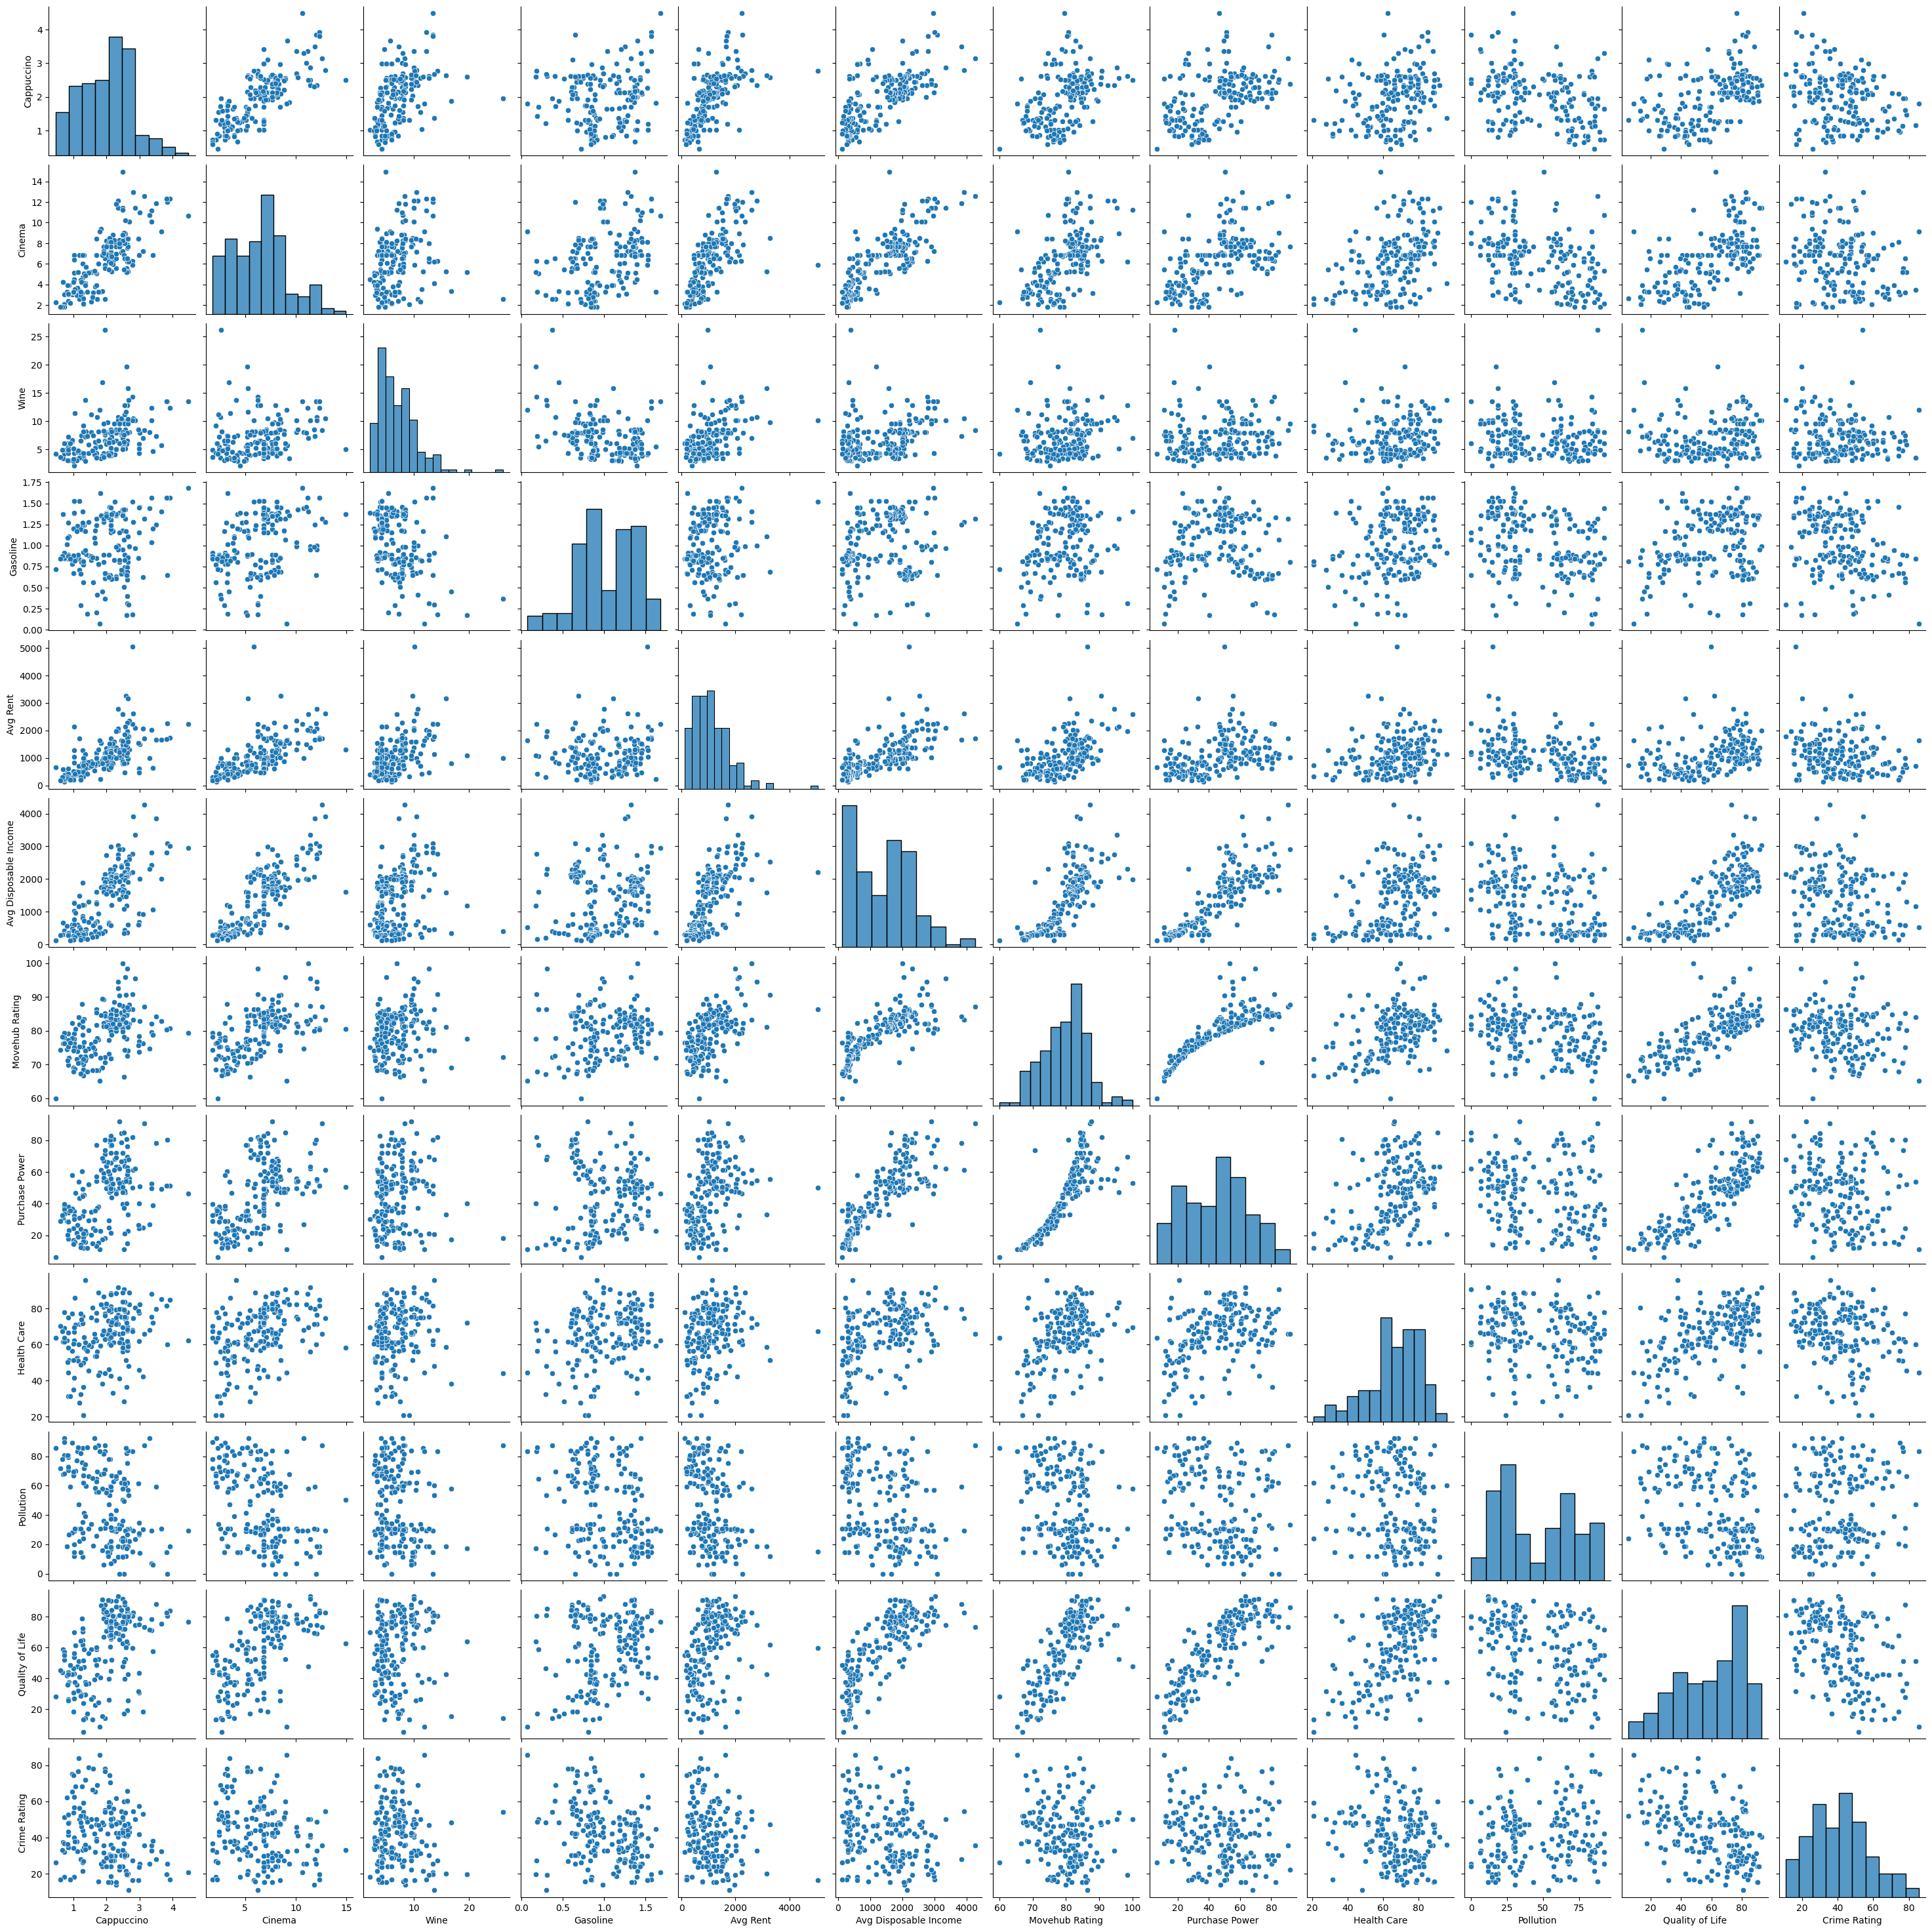

In [5]:
# Now, we would like to create a pair plot on all the numerical variables
df_numerical = df.iloc[:, 2:]
sns.pairplot(data=df_numerical)

### Pairwise Scatterplot Results
1. The majority of the variables in this dataset are numerical variables. Based on the pairwise scatterplots, there is one clear outlier with a large distance from the main cluster in the plots containing wine and avg rent variables. 

### Dendrograms for Outlier Detection

Next, we would like to detect high-dimensional outliers with single-linkage dendrograms. The single-linkage dendrogram algorithm is more likely to detect outliers than the average-linkage or complete-linkage algorithms.


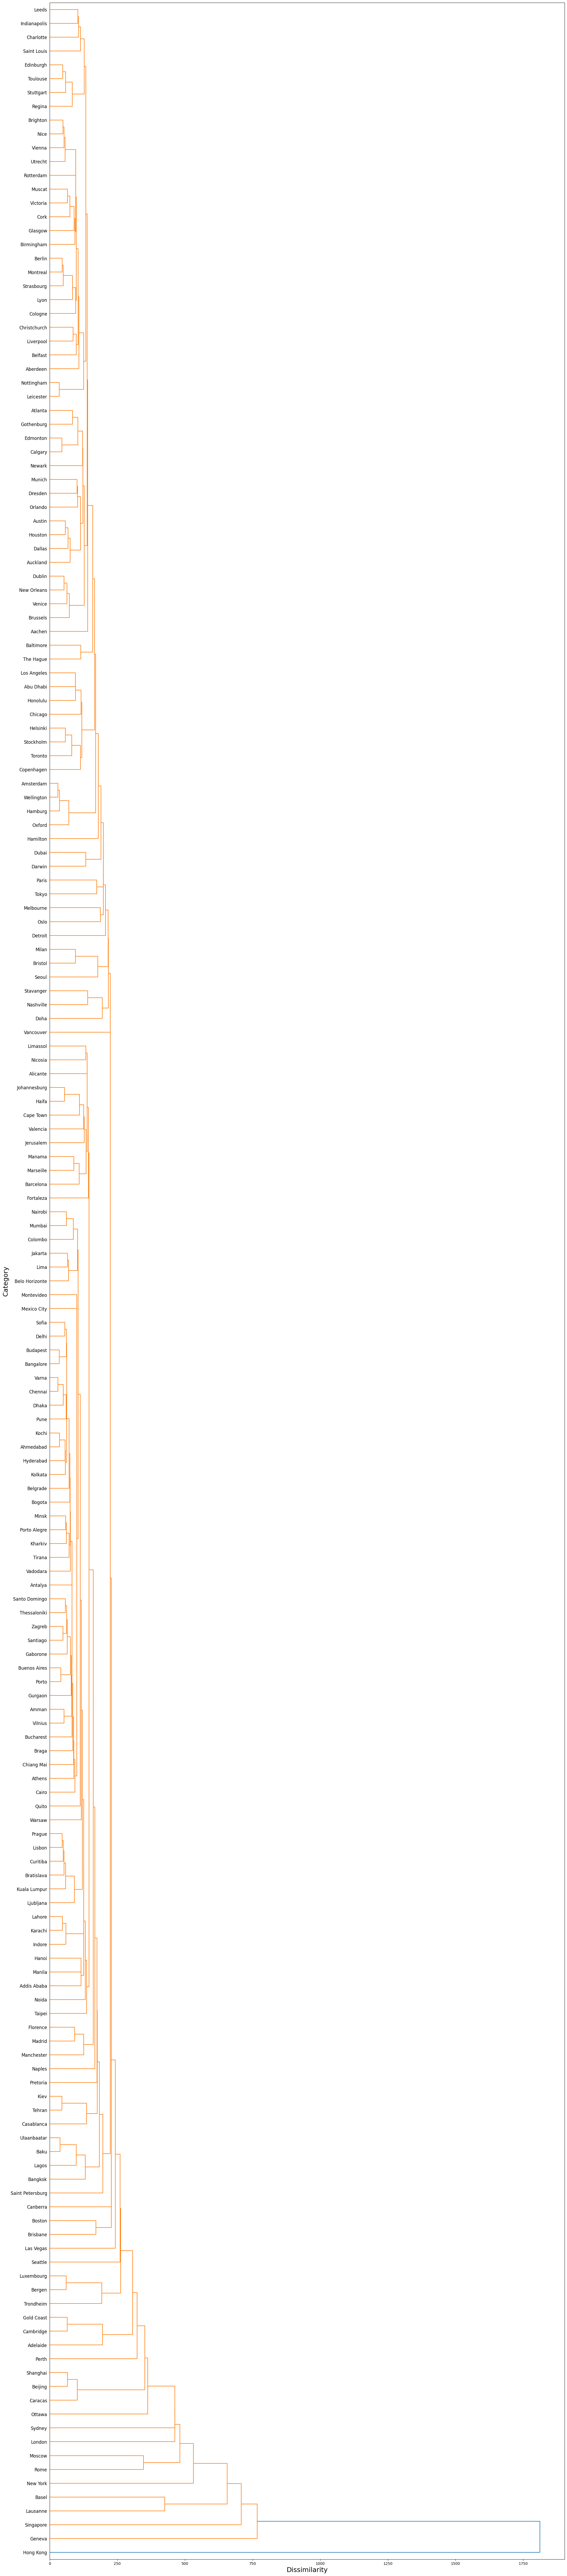

In [6]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

dm = pdist(df_numerical, metric='euclidean')
Z = linkage(dm, method='single')

fig, ax = plt.subplots(figsize=(25, 125))
d = dendrogram(Z, orientation='right', labels=df['City'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Category', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

### Outlier Identification with Single-Linkage Dendrogram Results

Hong Kong is an obvious outlier in this dataset, so we will consider removing it from our analysis.

#### Explanation

Because our research goal is to cluster different cities based on city information, the outlier might bias the interpretation of some predictors on the final clustering results. The pros of dropping them is that we can draw general conclusions from the dataset which meets our research goals. However, the cons are that the final clustering algorithms might not be robust as they do not take into account marginal cases.

### Noise Detection
We will first remove the aforementioned outliers and detect noises for the rest of the dataset.

Then, to check for data noises, we plot the k=2, ..., k=9 distance plot

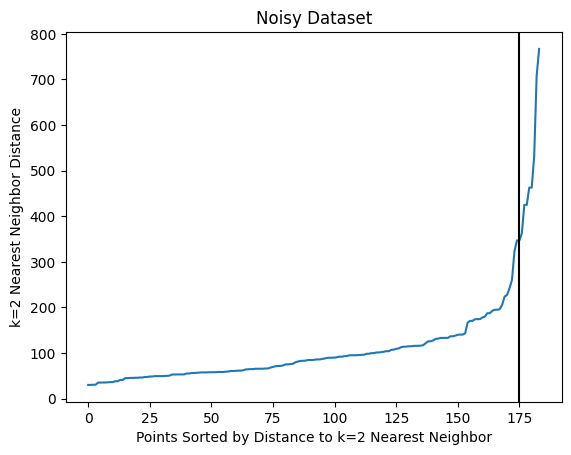

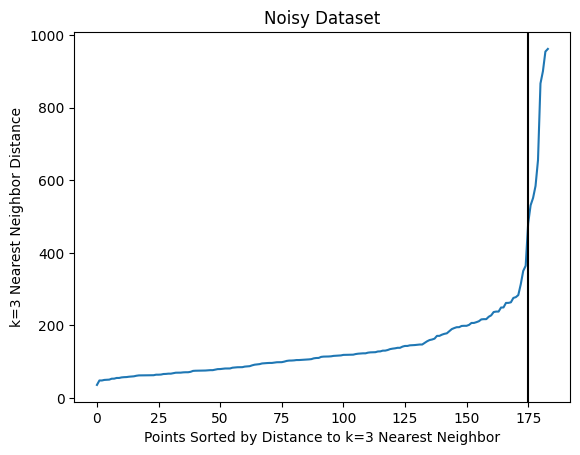

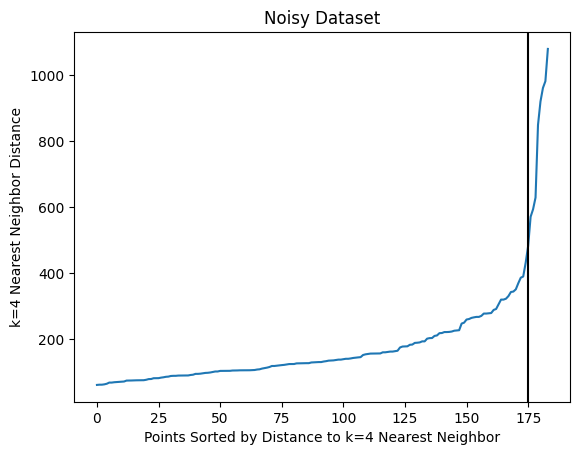

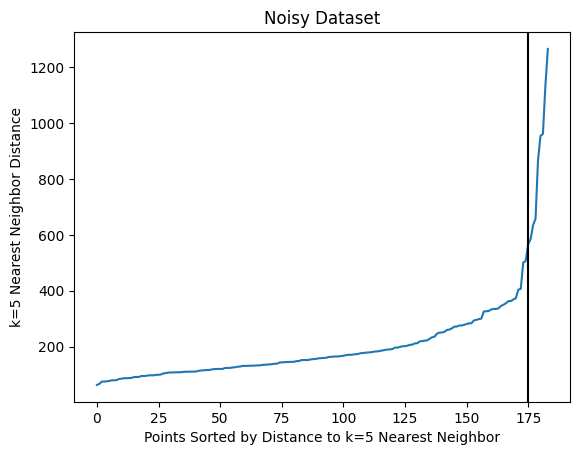

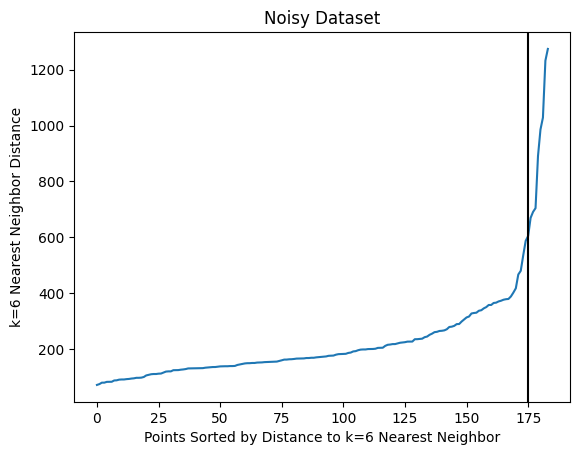

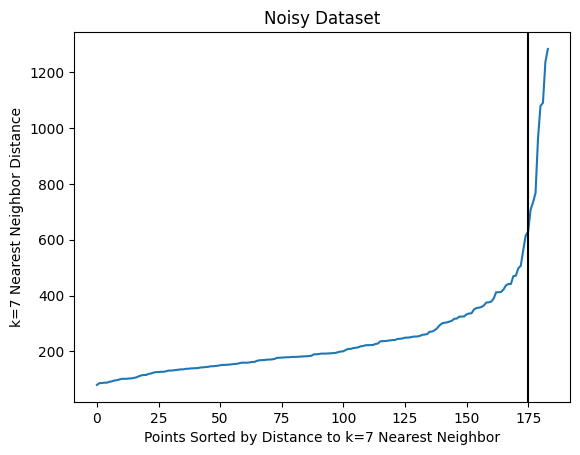

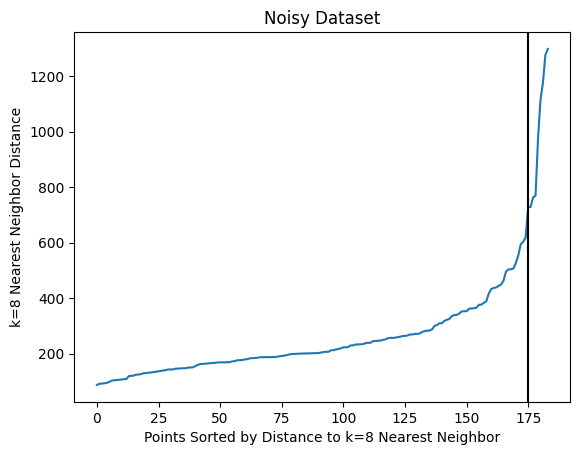

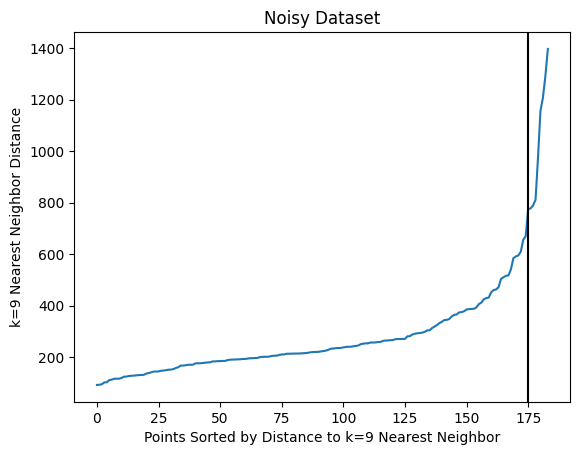

In [7]:
# Filter df
df_subset_outlier_removal = df[~df['City'].isin(['Hong Kong'])]

X_numerical = df_subset_outlier_removal.iloc[:, 2:]


from sklearn.neighbors import NearestNeighbors
#Find the distance of the kth nearest neighbor
for k in range(2,10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_numerical)
    distances, indices = nbrs.kneighbors(X_numerical)

    plt.plot(np.sort(distances.T[k-1]))
    plt.axvline(x=175, color='black')
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('Noisy Dataset')
    plt.show()

In [8]:
df_subset_outlier_removal.shape

(184, 14)

### Noisy Data Conclusion

For k=2...k=9 nearest neighbor plots, there is a dramatic jump in nearest neighbor distances when the number of observations is 175, which indicates that 9 noisy data points exist in the current dataset. Based on the information of noisy data obtained, we can pick reasonable values of $\epsilon$ when using DBSCAN algorithms for clustering. 

* In the k=2-5 nearest neighbors plot, we see that the closest neighbor of the 9 "noise points" is a distance of at least $\epsilon\approx 500$ away. Thus, if we were to set $minpts=2$, then we would want to set this $\epsilon\leq  500$.
* In the k=6-9 nearest neighbors plot, we see that the closest neighbor of the 9 "noise points" is a distance of at least $\epsilon\approx 700$ away. Thus, if we were to set $minpts=4$, then we would want to set this $\epsilon\leq  700$. Setting this value less than $\epsilon\leq  700$ could create even more noise points and/or more clusters in the dataset.

### Other Dataset Cleaning

We don't think there are any other data cleaning steps for this particular dataset

## 4. Basic Descriptive Analytics

In [9]:
#seperate numerical data 
df_num = df_subset_outlier_removal.select_dtypes(include = ['float64', 'int64'])

#summary of the numerical data
df_num.describe()

Cappuccino      Cinema        Wine    Gasoline     Avg Rent  \
count  184.000000  184.000000  184.000000  184.000000   184.000000   
mean     1.973859    6.464457    7.024076    1.011087  1078.585217   
std      0.762018    2.743758    3.380149    0.348088   611.958976   
min      0.460000    1.810000    2.130000    0.070000   120.680000   
25%      1.310000    4.237500    4.260000    0.780000   614.947500   
50%      2.085000    6.820000    6.335000    0.985000   980.650000   
75%      2.490000    7.970000    8.317500    1.322500  1412.445000   
max      4.480000   14.950000   26.150000    1.680000  3268.840000   

       Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
count             184.000000      184.000000      184.000000   184.000000   
mean             1389.369348       79.575380       45.555326    65.983315   
std               911.863618        6.657968       20.428574    14.983337   
min               120.680000       59.880000        6.380000    20.830000   
25%               513.577500       74.992500       28.815000    58.880000   
50%              1493.255000       80.645000       47.775000    67.635000   
75%              2045.960000       84.020000       60.407500    77.295000   
max              4266.110000      100.000000       91.850000    95.960000   

        Pollution  Quality of Life  Crime Rating  
count  184.000000       184.000000    184.000000  
mean    46.073533        59.036304     41.750652  
std     25.937334        22.214216     16.214349  
min      0.000000         5.290000     10.860000  
25%     23.897500        42.437500     29.702500  
50%     38.185000        63.335000     41.420000  
75%     68.252500        78.175000     51.097500  
max     92.420000        93.050000     85.700000

In [10]:
#seperate the categorical data
df_cat = df_subset_outlier_removal.select_dtypes(include = ['object'])
print(df_cat.head())

#summary of the categorical data
df_cat.describe()

        City        Country
0   Lausanne    Switzerland
1     Geneva    Switzerland
2      Basel    Switzerland
3      Perth      Australia
4  Nashville  United States


City        Country
count        184            184
unique       184             78
top     Lausanne  United States
freq           1             19

[('Cappuccino', 'Cinema'),
 ('Cappuccino', 'Avg Rent'),
 ('Cappuccino', 'Avg Disposable Income'),
 ('Cinema', 'Cappuccino'),
 ('Cinema', 'Avg Rent'),
 ('Cinema', 'Avg Disposable Income'),
 ('Cinema', 'Movehub Rating'),
 ('Cinema', 'Purchase Power'),
 ('Cinema', 'Quality of Life'),
 ('Avg Rent', 'Cappuccino'),
 ('Avg Rent', 'Cinema'),
 ('Avg Rent', 'Avg Disposable Income'),
 ('Avg Rent', 'Movehub Rating'),
 ('Avg Disposable Income', 'Cappuccino'),
 ('Avg Disposable Income', 'Cinema'),
 ('Avg Disposable Income', 'Avg Rent'),
 ('Avg Disposable Income', 'Movehub Rating'),
 ('Avg Disposable Income', 'Purchase Power'),
 ('Avg Disposable Income', 'Quality of Life'),
 ('Movehub Rating', 'Cinema'),
 ('Movehub Rating', 'Avg Rent'),
 ('Movehub Rating', 'Avg Disposable Income'),
 ('Movehub Rating', 'Purchase Power'),
 ('Movehub Rating', 'Quality of Life'),
 ('Purchase Power', 'Cinema'),
 ('Purchase Power', 'Avg Disposable Income'),
 ('Purchase Power', 'Movehub Rating'),
 ('Purchase Power', 'Qualit

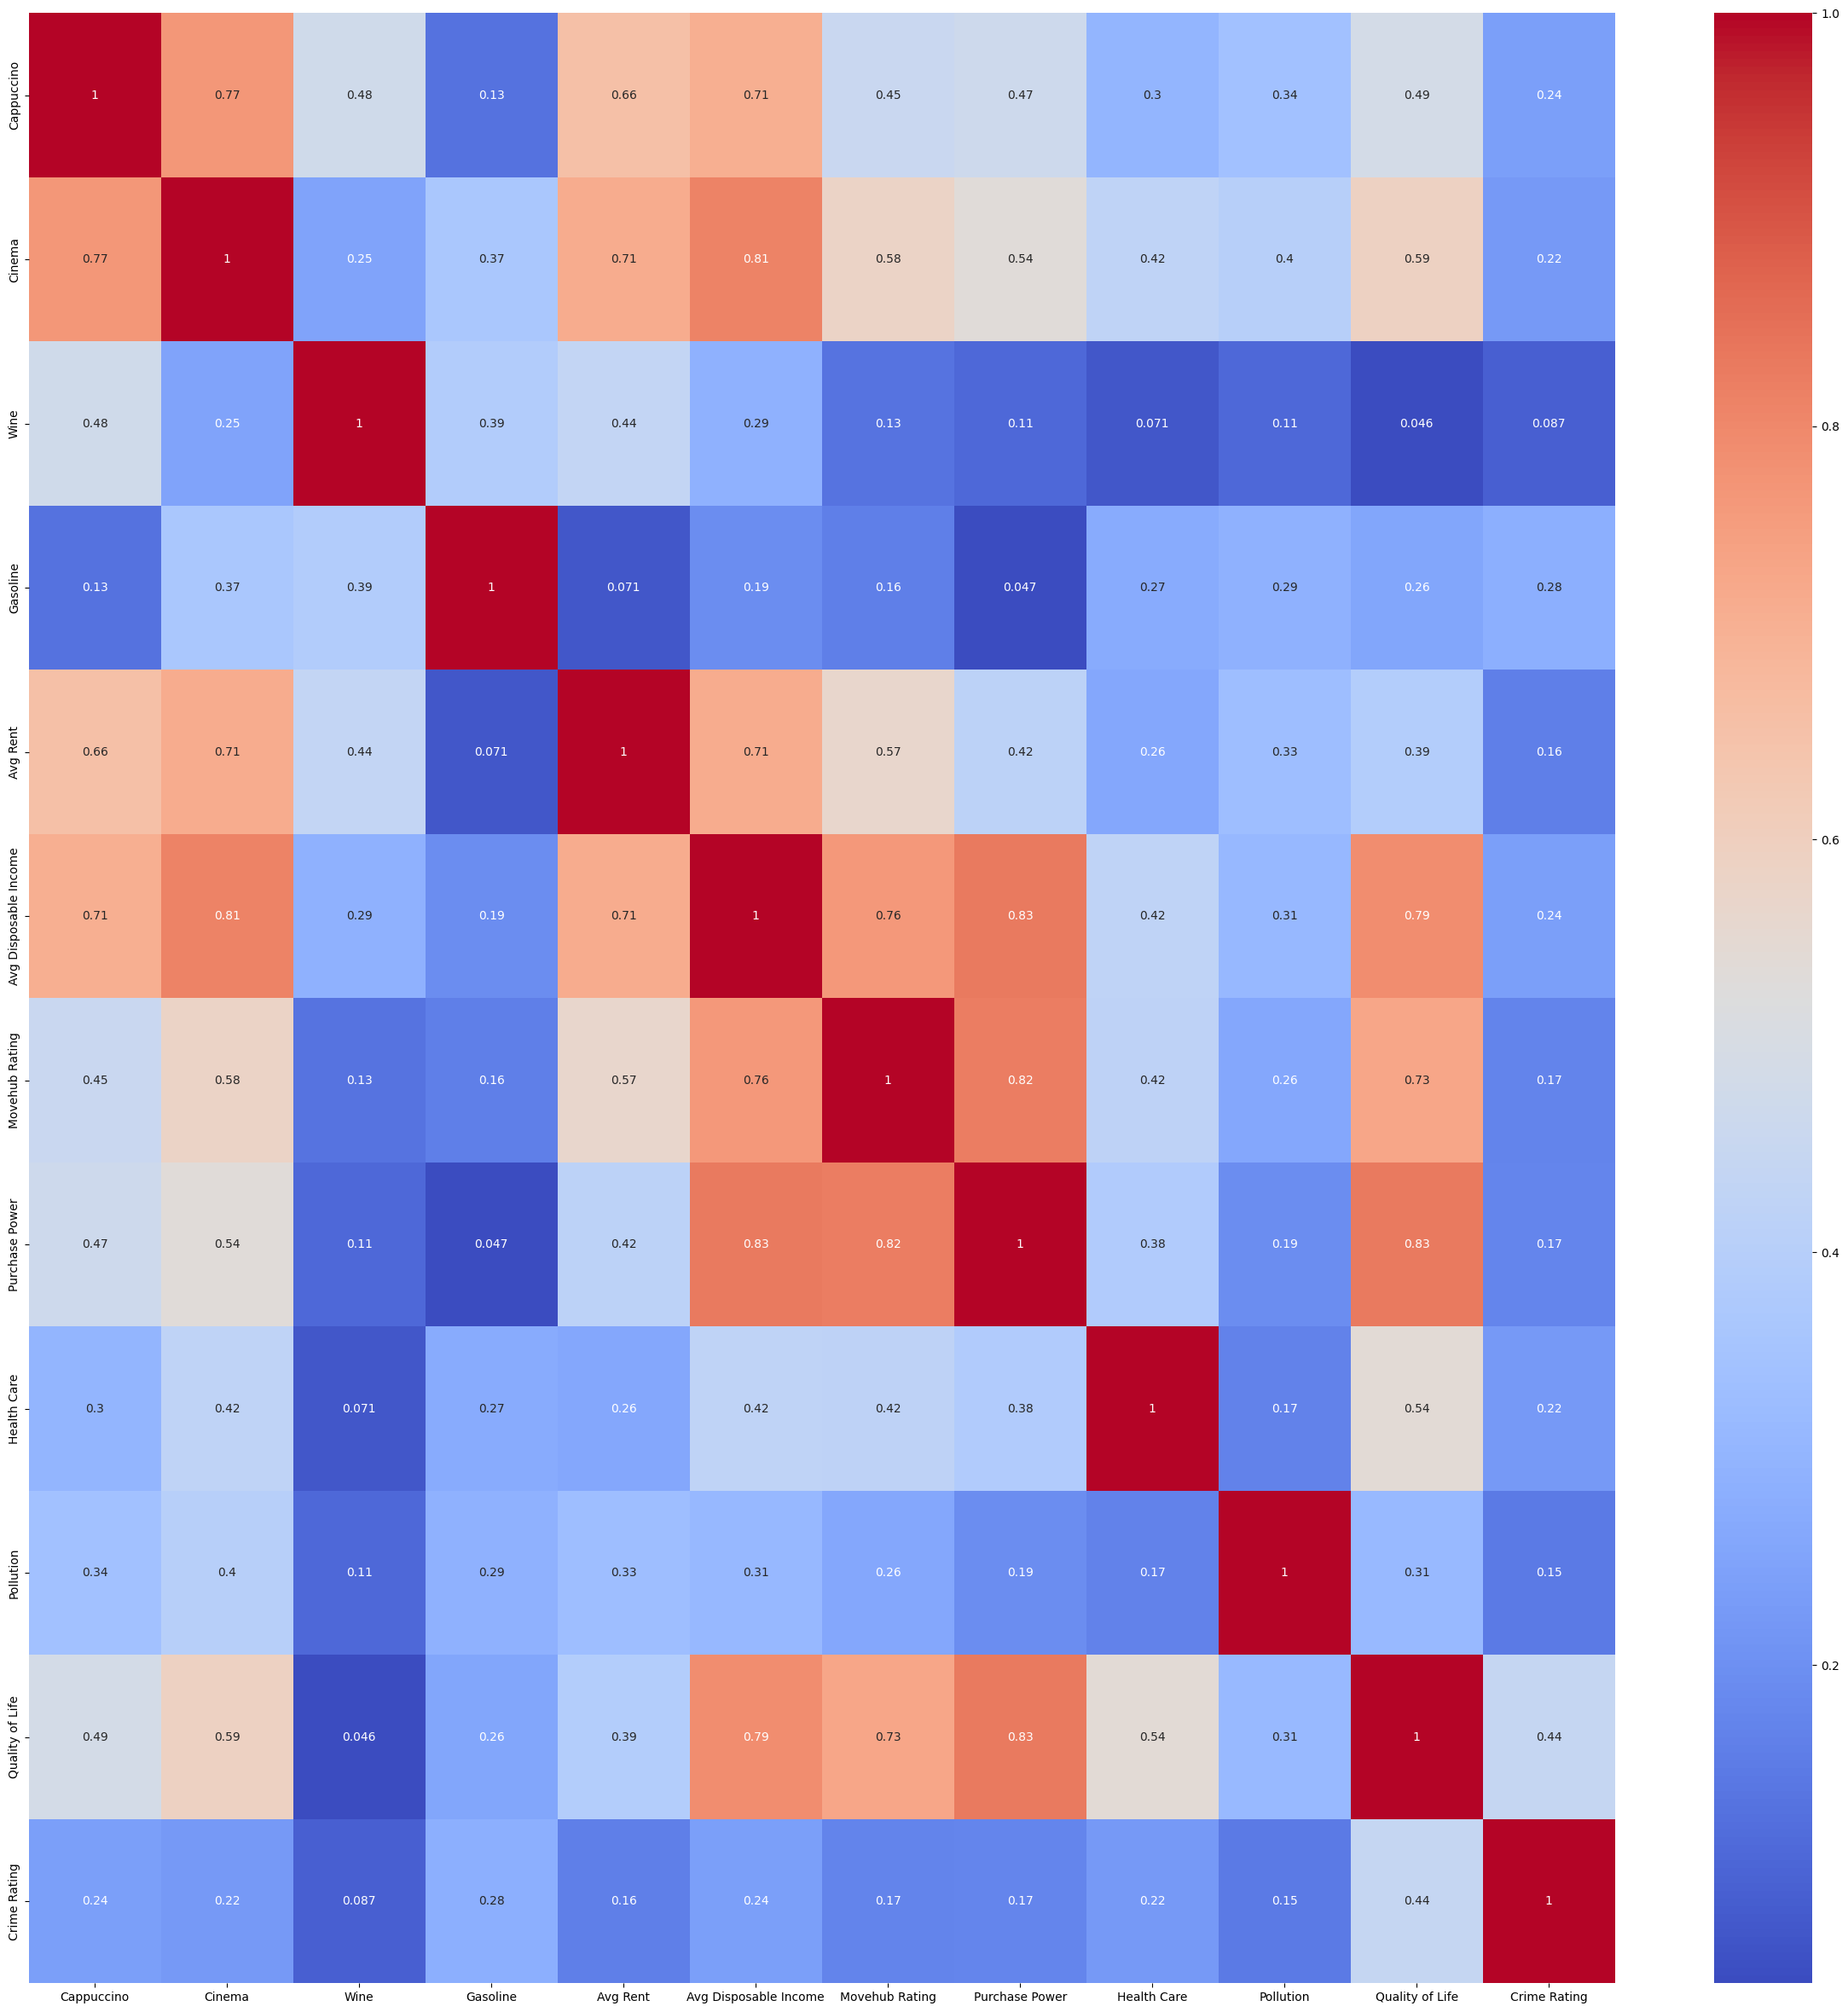

In [11]:
#pairwise correlation of numerical data
df_num_corr = df_num.corr()
df_num_corr

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_num_corr), annot = True, cmap = 'coolwarm')

high_corr_pairs = [(column, correlated_column) 
                   for column in df_num_corr.columns 
                   for correlated_column in  df_num_corr.columns 
                   if (abs(df_num_corr.loc[column, correlated_column]) > 0.5) and (column != correlated_column)]

high_corr_pairs


There's a lot of correlation within this dataset for example, Avg Disposable Income is highly correlated with Quality of Life, Purchase Power, Movehub Rating, Avg Rent, and Cinema and Cappuccino price. Purchase power is highly correlated with Movehub Rating, and so on.

<Axes: >

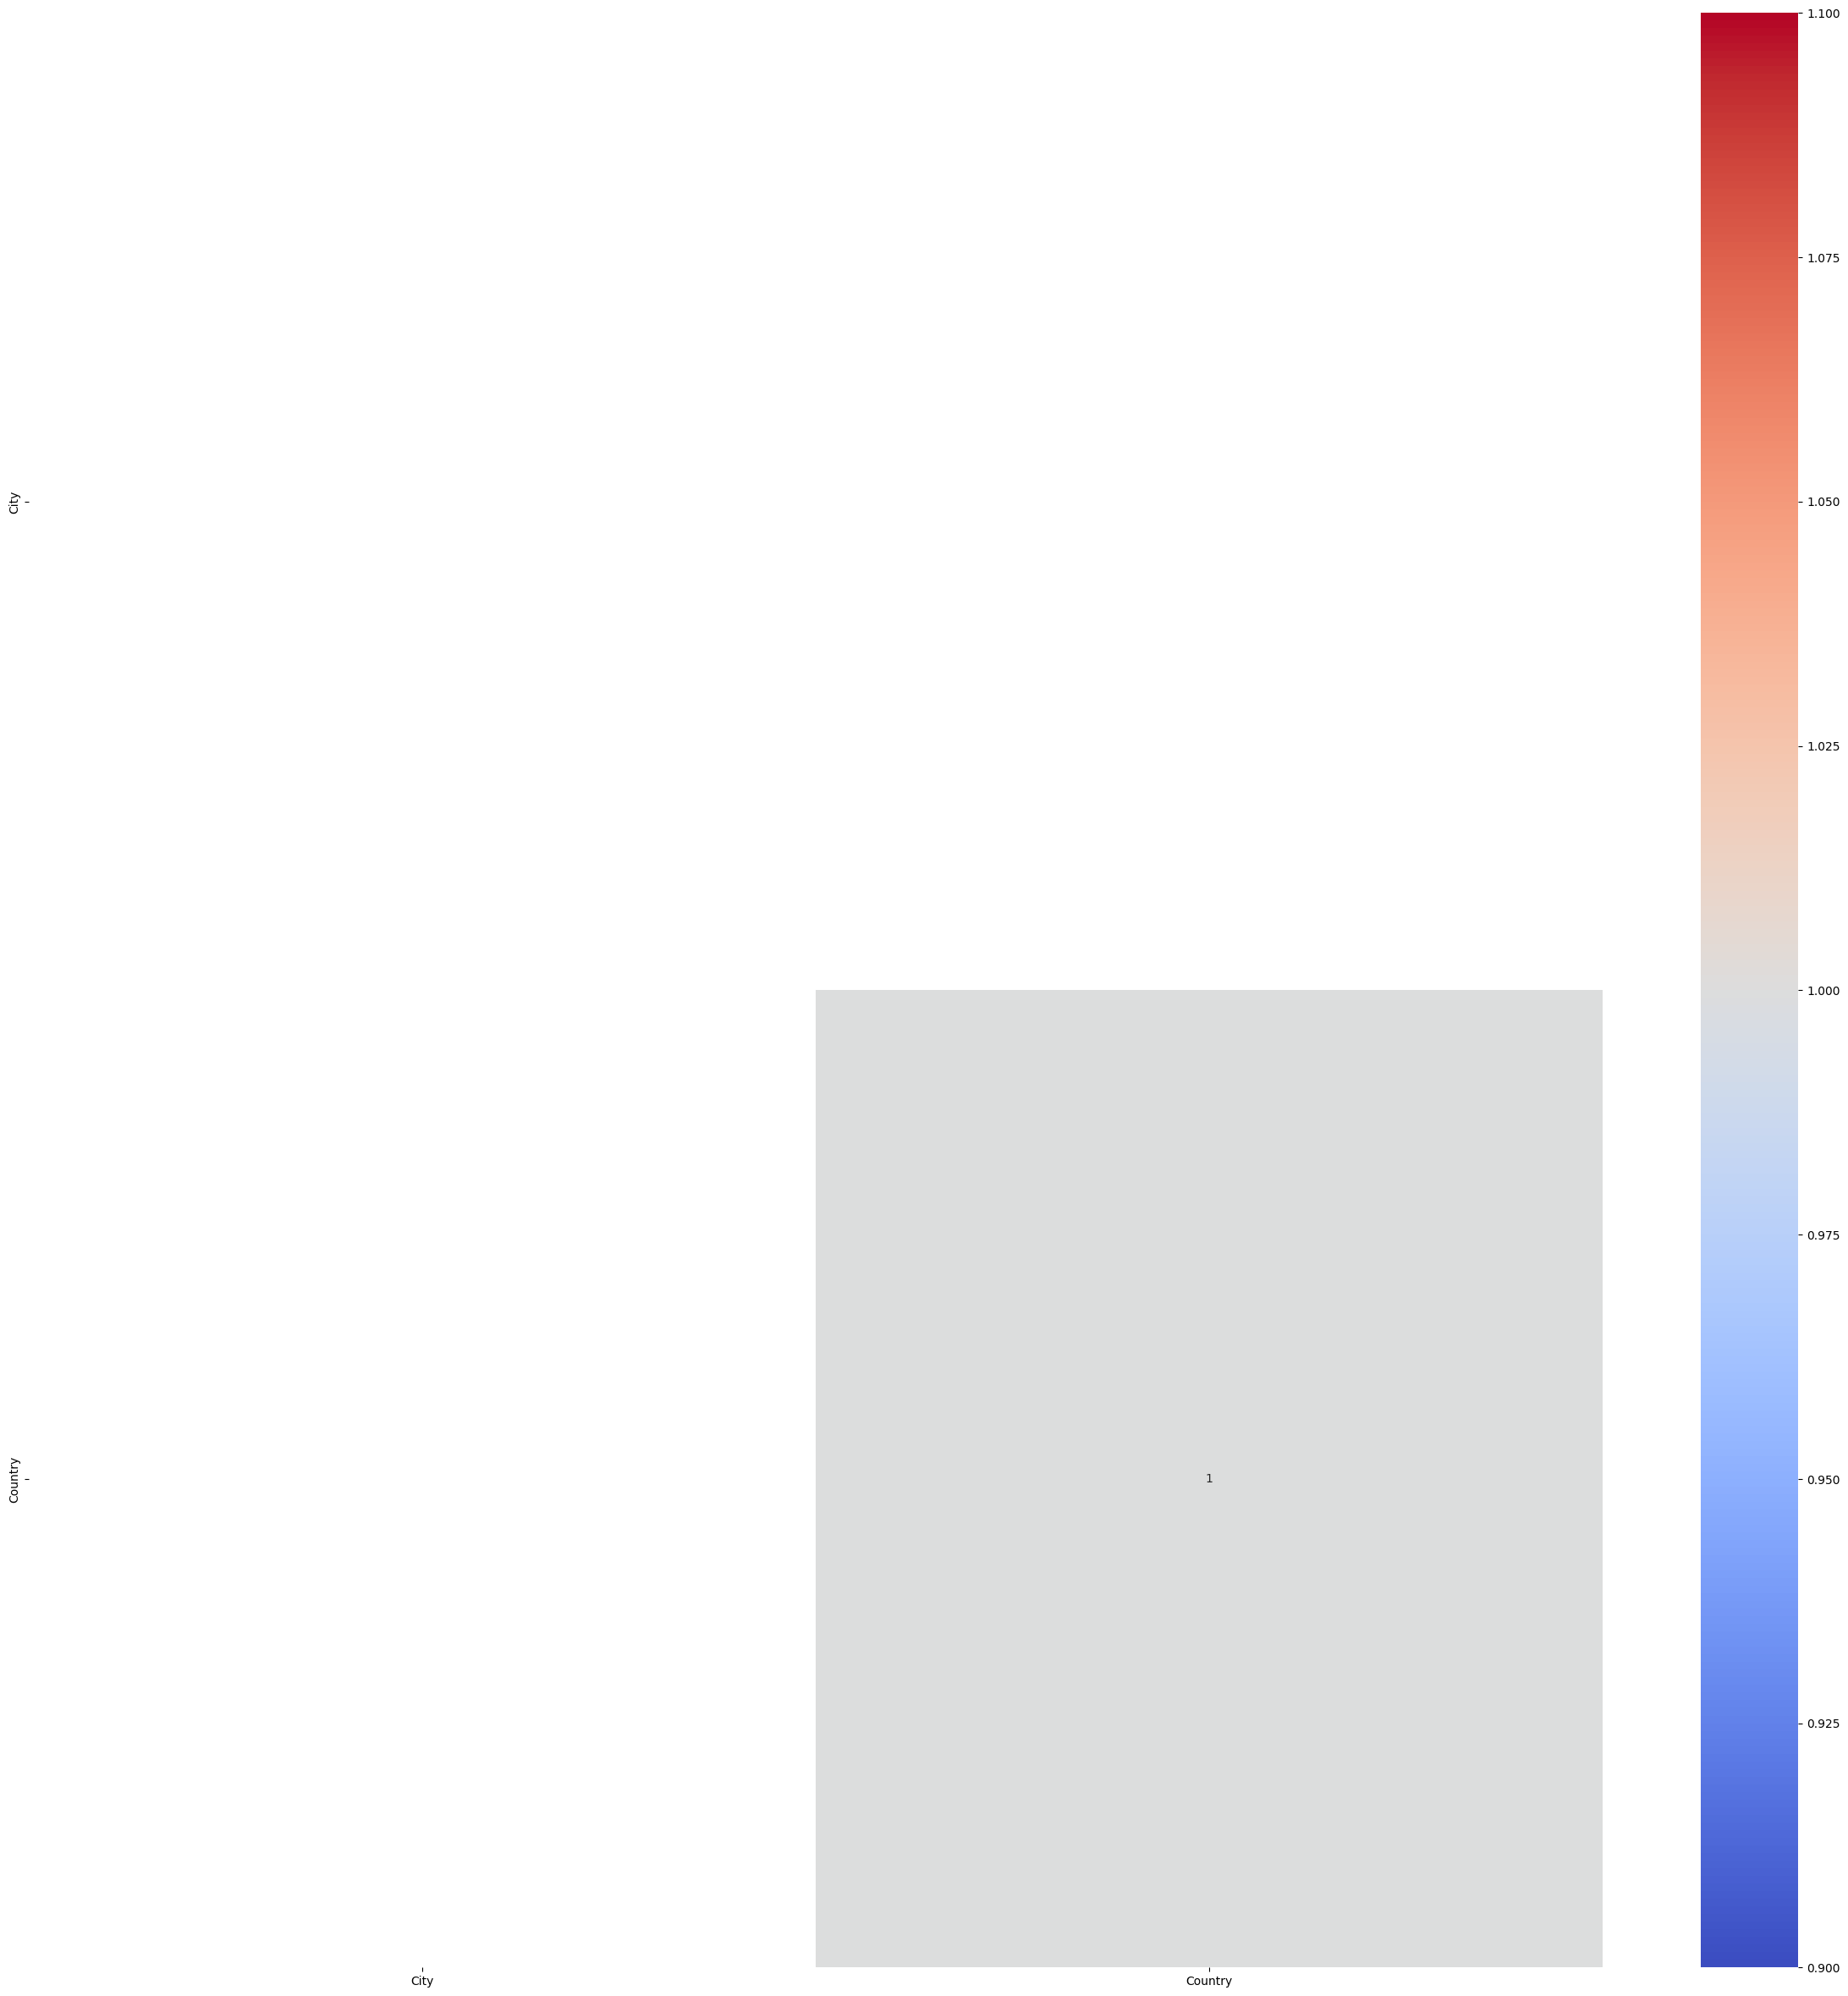

In [12]:
#contingency table for categorical variables
import pandas as pd
from scipy.stats import chi2_contingency

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#pairwise correlation of categorical data
rows= []

for var1 in df_cat:
    col = []
    for var2 in df_cat :
        cramers =cramers_corrected_stat(pd.crosstab(df_cat[var1], df_cat[var2]))
        col.append(round(cramers,2)) # Keeping of to two decimal
    rows.append(col)

cramers_results = np.array(rows)
df_cat_corr = pd.DataFrame(cramers_results, columns = df_cat.columns, index =df_cat.columns)

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_cat_corr), annot = True, cmap = 'coolwarm')



According to the heatmap, the categorical variables does not have significant pairwise correlation.

<Axes: >

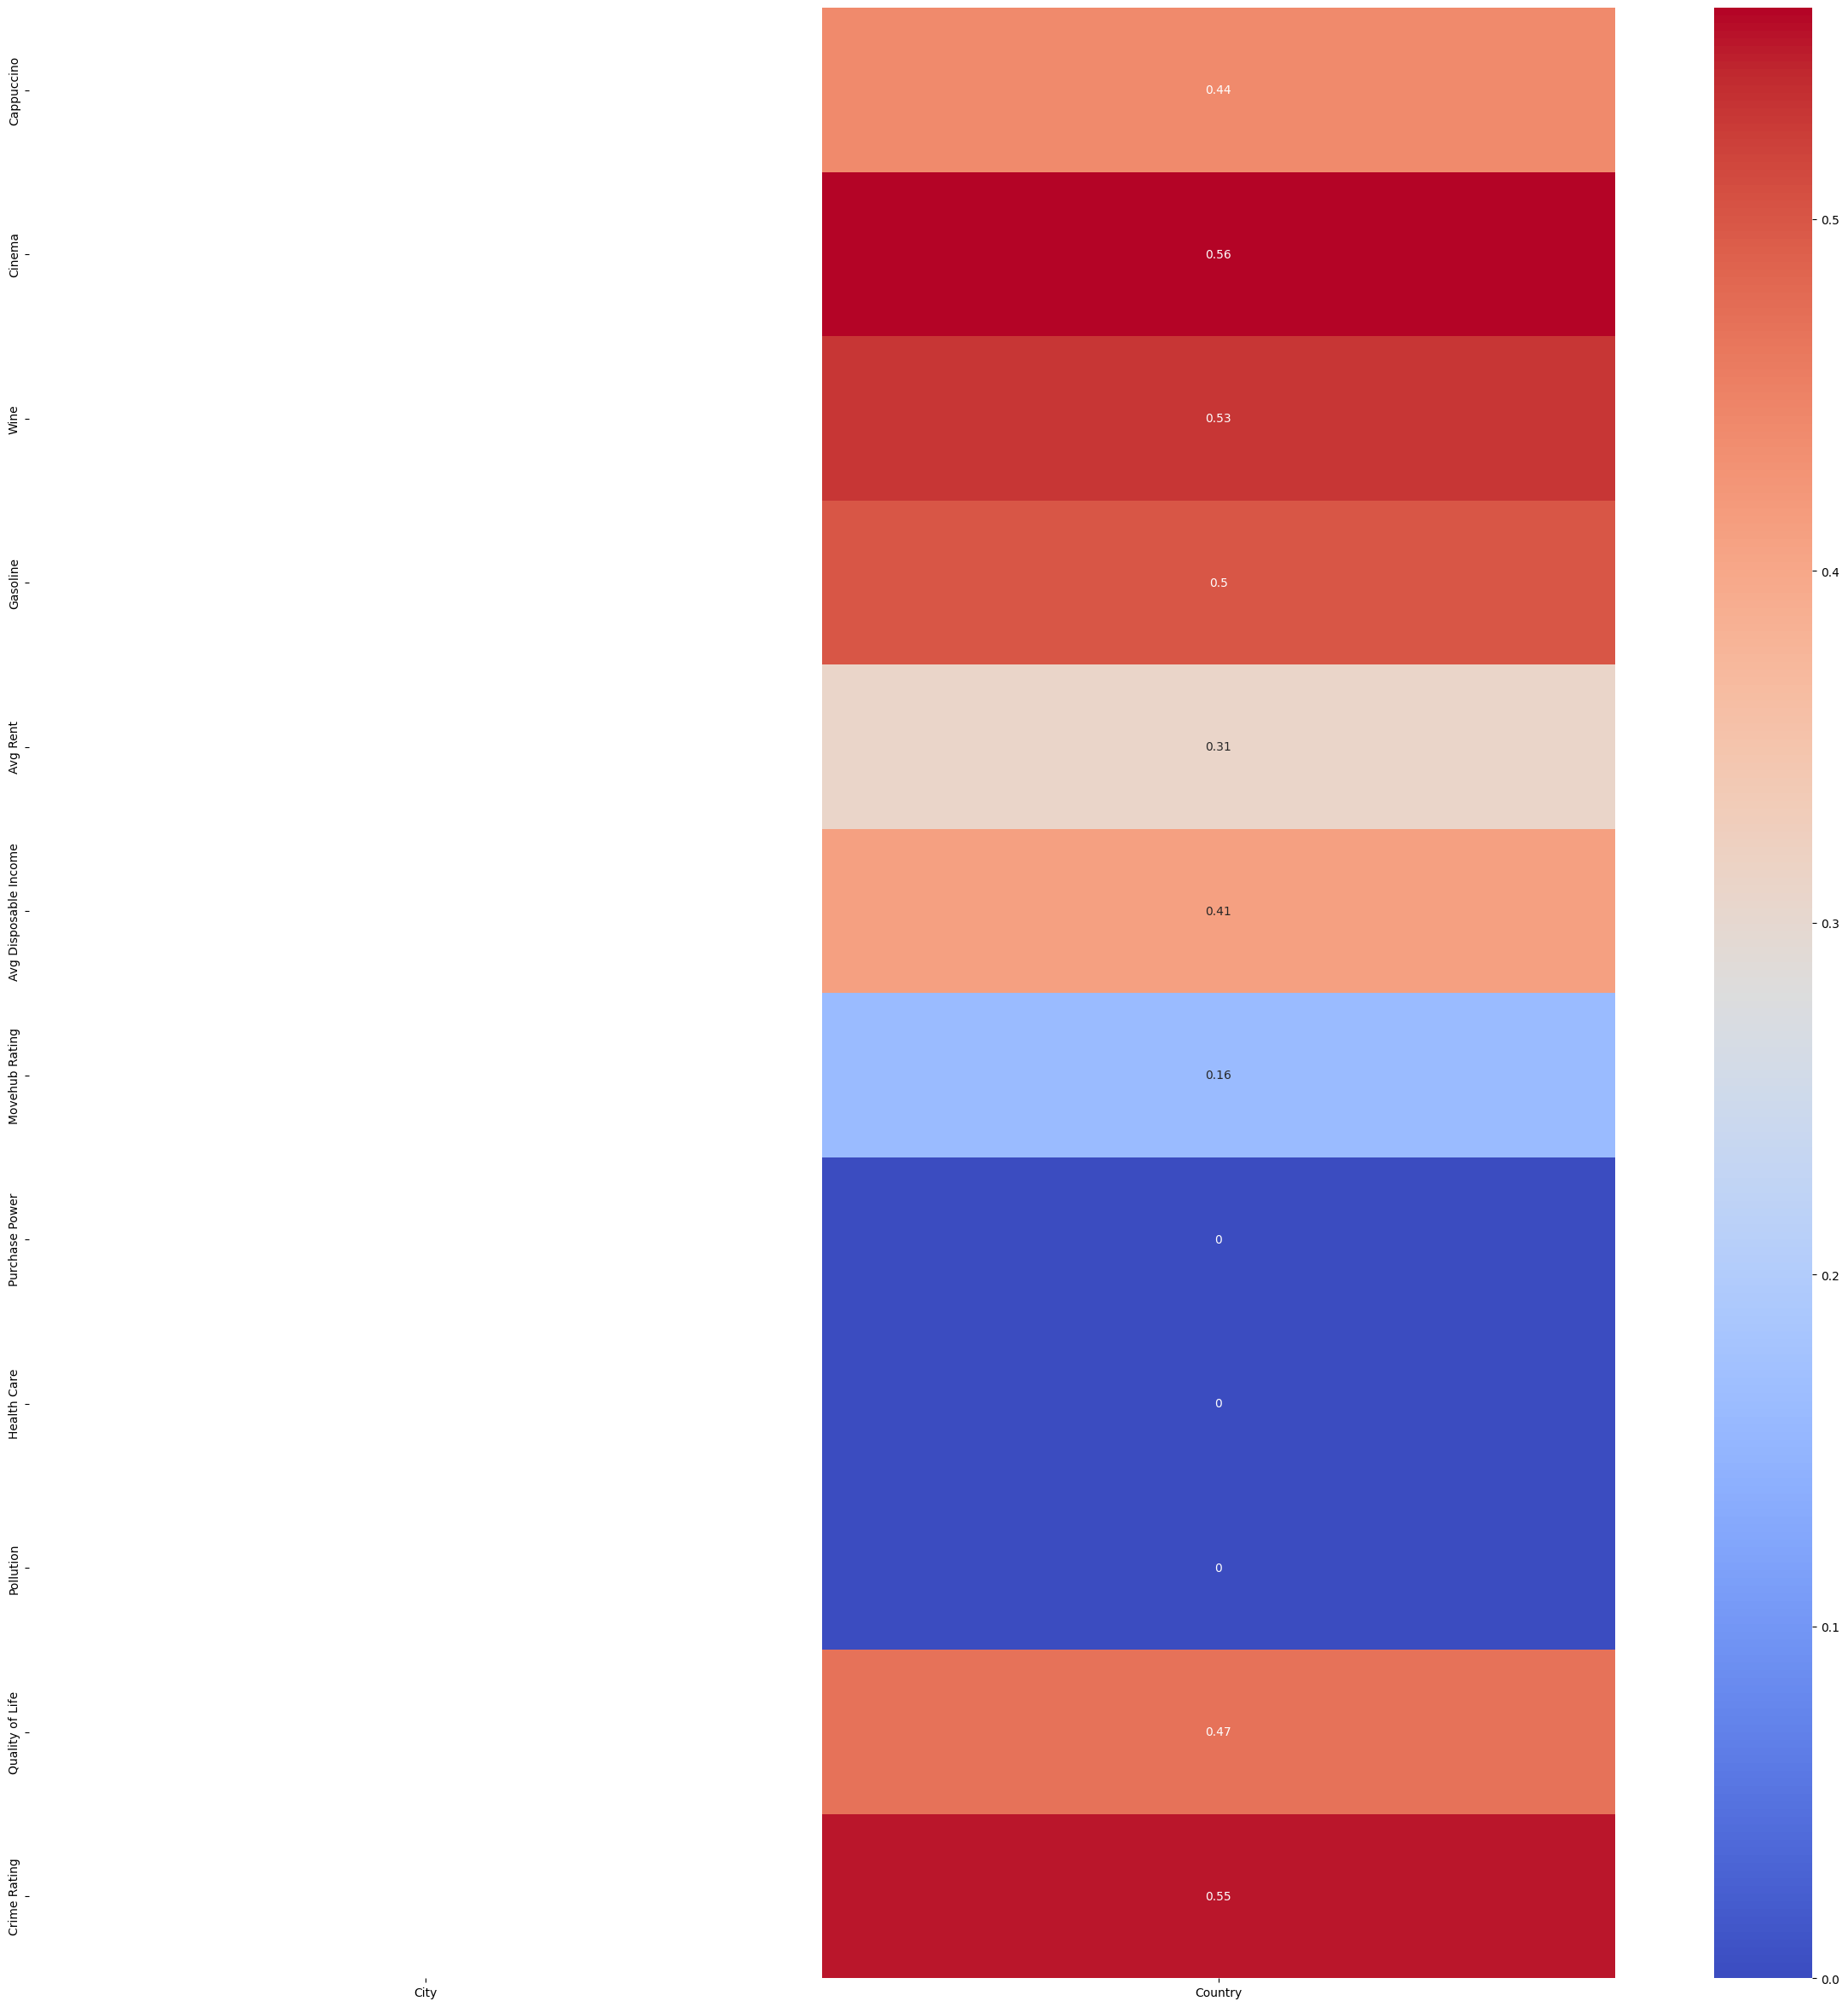

In [13]:
#pairwise relationship between numerical variables and categorical varaiables
rows = []

for var1 in df_num:
    col = []
    for var2 in df_cat :
        cramers =cramers_corrected_stat(pd.crosstab(df_num[var1], df_cat[var2]))
        col.append(round(cramers,2)) # Keeping of to two decimal
    rows.append(col)

cramers_results = np.array(rows)
df_num_cat_corr = pd.DataFrame(cramers_results, columns = df_cat.columns, index =df_num.columns)

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_num_cat_corr), annot = True, cmap = 'coolwarm')


For numerical and categorical variables, That Country is highly correlated with crime rating, quality of life, income, gasoline, wine, cinema, and cappocino prices. 

## 5. Scaling Decisions

We want to standardize the dataset, since some features have a higher std that can negatively impact the clustering model results. By scaling the data, it would normalize stds to be lower.

In [14]:
from sklearn.preprocessing import StandardScaler

numeric_columns = df_subset_outlier_removal.select_dtypes(include=['number']).columns
categorical_columns = df_subset_outlier_removal.select_dtypes(exclude=['number']).columns

X_numeric = df_subset_outlier_removal[numeric_columns]
X_categorical = df_subset_outlier_removal[categorical_columns]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

X_categorical.reset_index(drop=True, inplace=True)
df_scaled = pd.concat([X_scaled, X_categorical], axis=1)

## 6. Clusterability and Clustering Structure

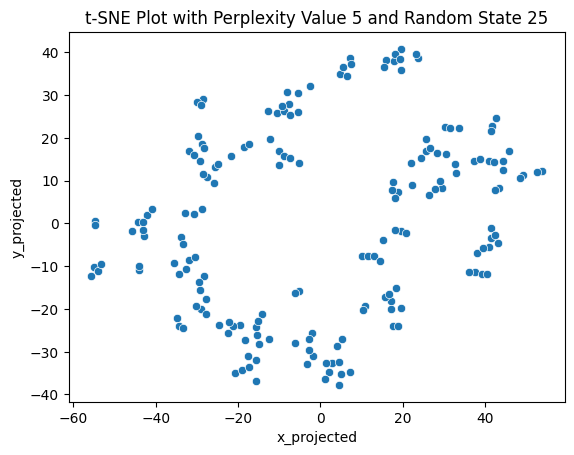

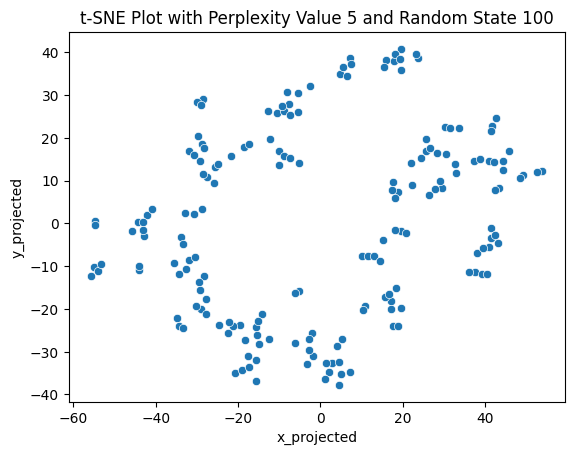

--------------------------------------------


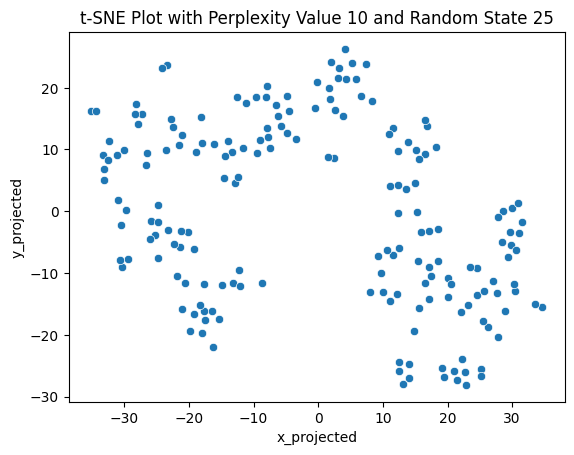

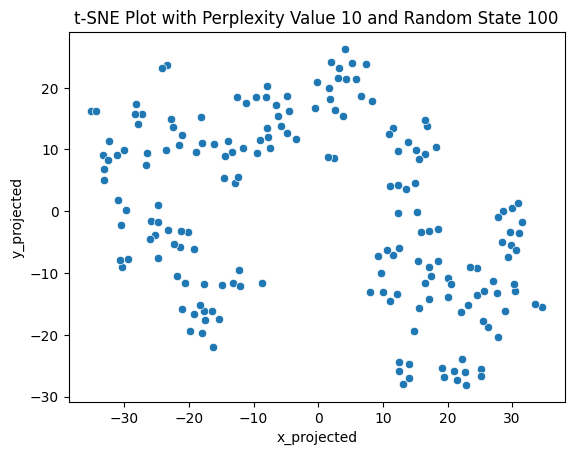

--------------------------------------------


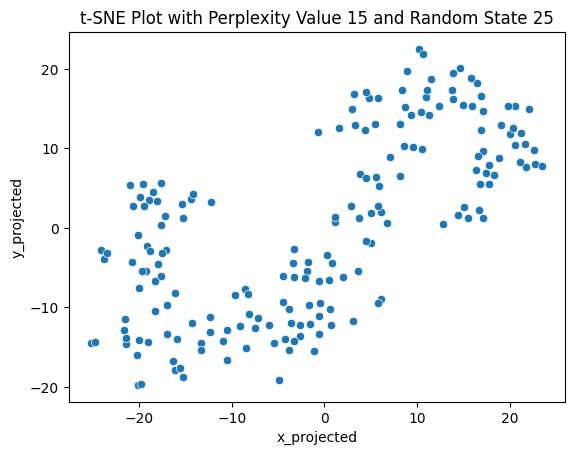

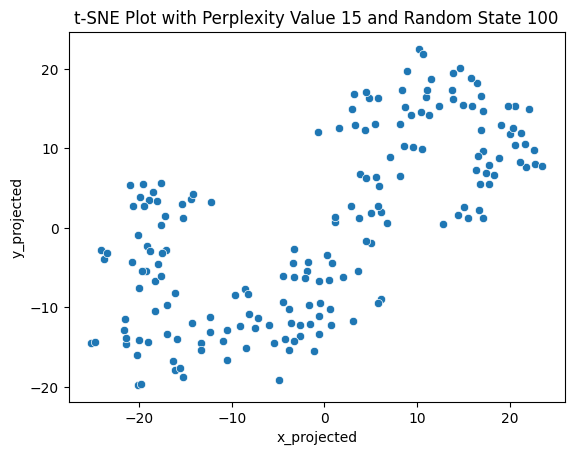

--------------------------------------------


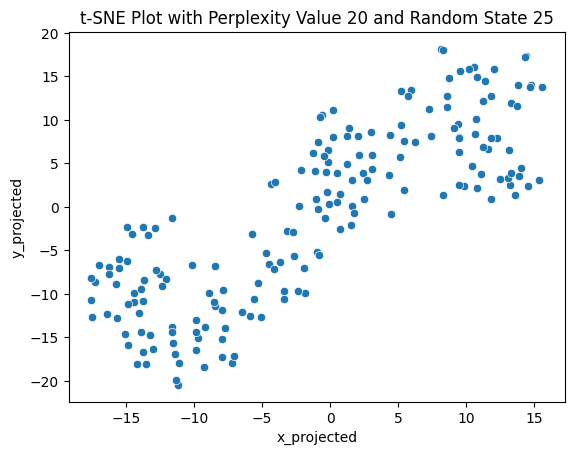

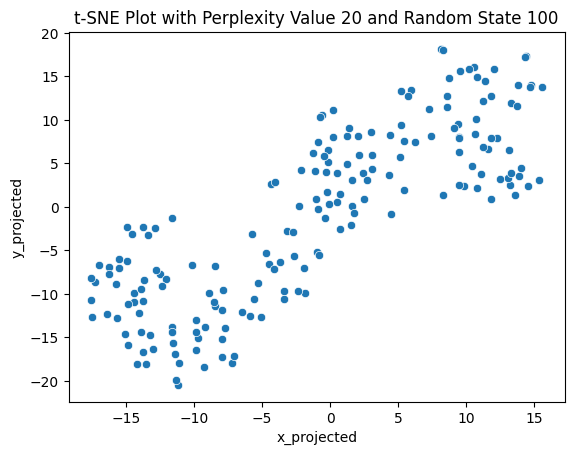

--------------------------------------------


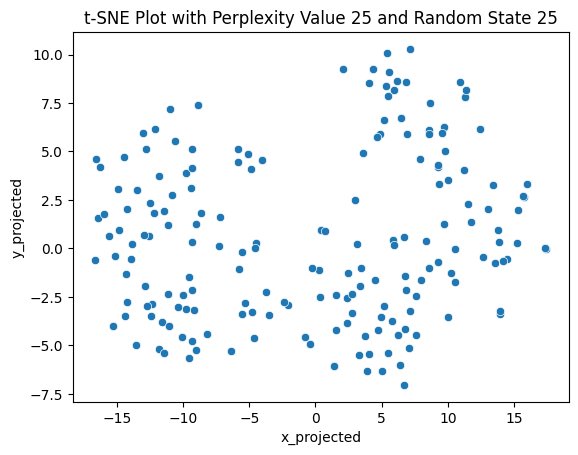

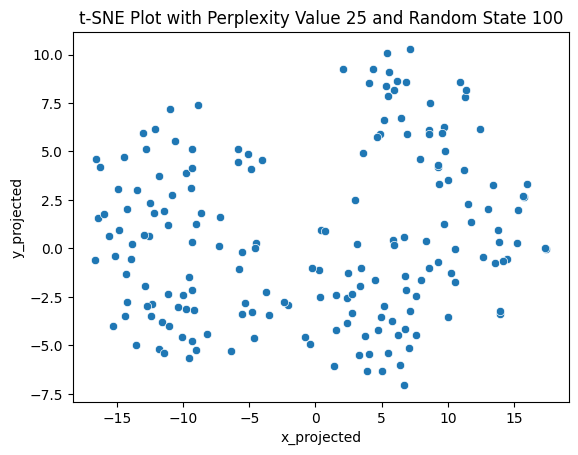

--------------------------------------------


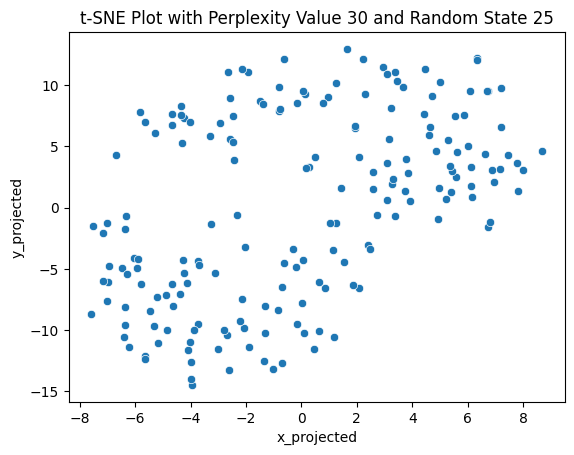

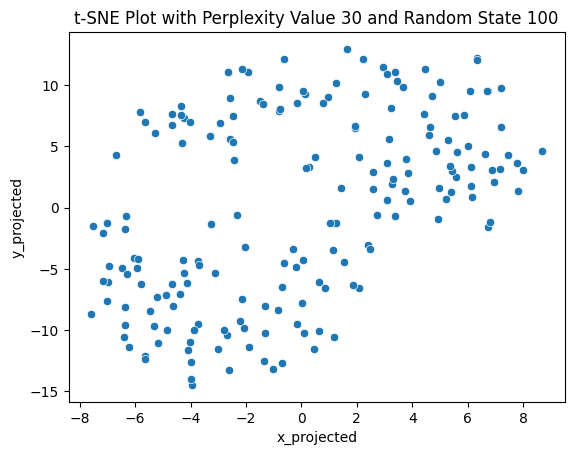

--------------------------------------------


In [15]:
from sklearn.manifold import TSNE
for perp in [5,10, 15, 20, 25, 30]:
    for rs in [25, 100]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
        data_tsne = tsne.fit_transform(df_scaled.select_dtypes(include='number'))
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_tsne.reset_index(drop=True, inplace=True)
        df_combo = pd.concat([df_scaled, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()
    print('--------------------------------------------')

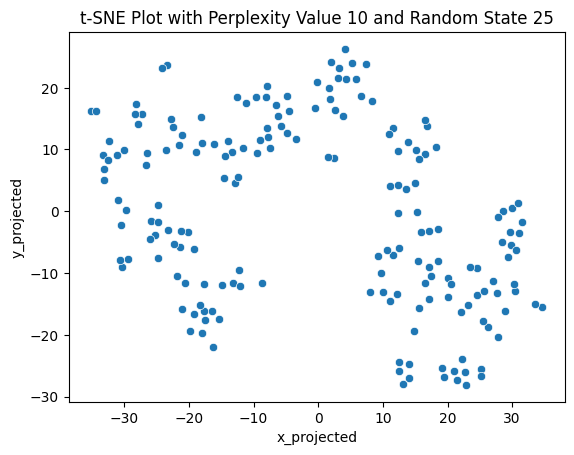

In [16]:
tsne = TSNE(n_components=2, perplexity=10, random_state=25)
data_tsne = tsne.fit_transform(df_scaled.select_dtypes(include='number'))
df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
df_tsne.reset_index(drop=True, inplace=True)
df_combo = pd.concat([df_scaled, df_tsne], axis=1)
sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(10, 25))
plt.show()

Based on the t-SNE plot of perplexity value of 10 and random state of 25:  
The TSNE plot shows that the dataset is clusterable. We can see seperation of two clusters in the plot.  
The shape of the clusters is elliptical.  
The clusters are balanced in size.  
The clusters are mostly well-seperated, with some random states and perplexity that are not well-seperated.  
There might be nested/sub clusters because there are some points that are not well-seperated. 
One attribute that might be useful for clustering is the the quality of life, because the two cluster might show the variation of the quality of life between different cities.  
TSNE can help determine the if there exist clustering structure, the cluster shape, the number of clusters, the number of objects in each cluster, whether the clusters are well-separated. However, it cannot determine the distance between objects and clusters in the original data, and the centroid, sparsity, and existence of noise or outliers in the original data.

## 7. Clustering Algorithm Selection Motivation - K-Prototype

Our research motivation is to allow individuals and stakeholders to identify places that are aligned with their preferences. Clustering the dataset would help segment data based on their similar features, allowing stakeholders to create uniform solutions for places with similarities. This approach saves them time and resources having to research each individual environment and  also ensures a more targeted and efficient strategy. For individuals, the clustering algorithm is able to create quick recommendations based on their preferences by looking at the difference in qualities between each cluster. This method not only simplifies the decision-making process for individuals looking for places that meet their specific needs but also enhances the accuracy and relevance of the recommendations provided. We chose K-Prototype as one of our clustering algorithms because our data contains numerical and categorical variables. K-prototype algorithms are built to handle mixed data clustering. The K-prototype algorithm begins by randomly assigning centroid and assigning each object to its closest prototype until the prototype of the previous iteration is the same as the last. It combines K-means and K-mode into an algorithm that can handle mixed data by using mean for numerical attributes and mode for categorical attributes. Since our T-SNE plot discovered clusters that are adequately separated and elliptical, the K-prototype algorithm could tackle the dataset. 


##### Algorithm Algorithm Selection Motivation 2 - Gaussian Mixture Algorithm

Again, the motivation is to find the ideal places for individuals and stakeholders. Clustering can give us insightful conclusions based on the features in the dataset. We chose Gaussian Mixture as another clustering algorithm because it can catch the underlying information that could be missed from the K-Prototype algorithm. Gaussian Mixture is a soft clustering algorithm which is more informative and flexible than hard clustering algorithms like K-means and K-prototype. It would give probability to each data point of the clusters that it belongs to; it would include the mixture weights for each Gaussian component. By using Gaussian Mixture Algorithm we can figure out the association between the features and provide informative clusters.


We believe it would be beneficial to perform a fuzzy clustering dataset. First of all, based on the structures of the t-SNE plot, the shapes of the clusters are not circular, and the subclusters from one main cluster are not well-separated. Therefore, a traditional k-means clustering may not perform well on the dataset. A fuzzy clustering, however, can identify the clusters when they are overlapping. In addition, for our research goals, we would like to tell whether different cities can be clustered together based on information such as quality of life or cost of living, using the membership score as opposed to a hard assignment of cities will be provide more insights into the association between cities rather than labeling cities as ‘A’ or ‘B’.


## 8. Clustering Algorithm Practical Considerations
#### Algorithm Practical Considerations 1 - K-Protoype
K-prototype is a non-deterministic algorithm because it starts by randomly assigning centroid. It is possible that it would end up at a local minimum instead of a global minimum. By running the algorithm again, it may find a different solution than the previous run. 
In a more complete analysis, ideally the algorithm would be run using a sequence of random states, then comparing the result of the cost function. Then, depending on the data and comparing the clusters suggested by the cost function, one can make an informed decision on the number of clusters and the centroid they want. 
If there are additional observations added to the dataset, the whole algorithm would have to be rerun with the newly added data. Unlike birch and mini-batch K-means, it is not built to handle constantly updating and enormous datasets. Without rerunning the algorithm, one can collect the prototype result from K-prototype and assign the new data to their closest prototype. 

##### Algorithm Practical Considerations 2 - Gaussian Mixture Algorithm

The algorithm is a non-deterministi algorithm because it randomly select a cluster and then randomly pick an object from the clusters to calculate the probability. 

If we are given additional data points, we would like to re-run the algorithm as the additional data points will affect the membership scores of each cluster from the clustering results. If we do not re-run the algorithm, we can calculate membership scores for the new data points based on the clustering results from the previous run. Them, the data points can be assigned to the cluster with the highest membership score.

## 9. Clustering Algorithm #1: K-Prototype



### Parameter Selection:

We create a k-prototype elbow plow that should indicate what number of clusters would be most effective for the dataset.

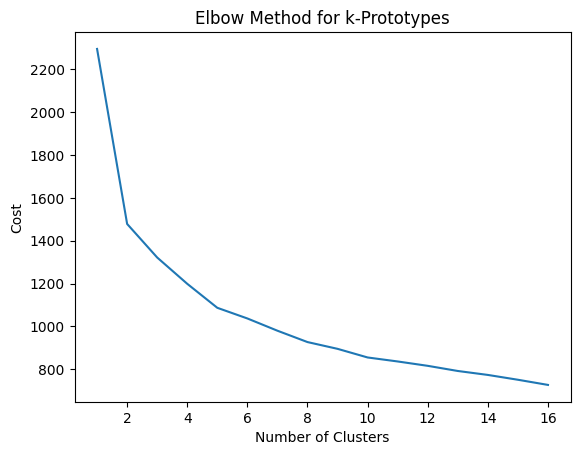

In [17]:
from kmodes.kprototypes import KPrototypes

proto_df = df_scaled

cost = []
for num_clusters in list(range(1,17)):
    kp = KPrototypes(n_clusters=num_clusters, random_state=100,gamma = 0.25)
    kp.fit_predict(proto_df, categorical=[12,13])
    cost.append(kp.cost_)

plt.plot(list(range(1,17)),cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for k-Prototypes')
plt.show()

From the k-prototype elbow plot, we can conclude the best number of clusters to select is 3, since that's where the eblow bends the best. If our clustering isn't the best at 3, we can also consider 2 and 5 clusters, since the plot indicates they may also be effective.

### Clustering the data:

In [18]:
from kmodes.kprototypes import KPrototypes

kp = KPrototypes(n_clusters=2, random_state=1000)
fit_clusters = kp.fit_predict(proto_df, categorical=[12,13])
df_combo['predicted_cluster']=fit_clusters

### Clustering Algorithm Results Presentation

In [19]:
df_combo

Cappuccino    Cinema      Wine  Gasoline  Avg Rent  \
0      1.547668  2.238629  0.408171  0.889879  1.041162   
1      1.087108  2.366539  1.028174  0.774652  2.505949   
2      2.008228  1.982808  0.096686  0.688232  0.935131   
3      1.179220  1.814698  0.906546 -0.118358  1.646018   
4      2.455630  2.023009  1.921097 -1.040176  1.931127   
..          ...       ...       ...       ...       ...   
179   -0.728815 -1.167440  0.090753 -2.365288 -1.069543   
180   -1.281487 -1.167440 -0.567815 -0.982562 -1.443248   
181   -0.978833 -1.167440 -0.143602 -1.011369 -1.429648   
182   -1.992066 -1.525589 -0.843701 -0.838528 -0.696083   
183   -1.399917 -1.547516 -0.294895 -0.492847 -1.431172   

     Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
0                 3.163401        1.149818        2.219344    -0.008922   
1                 2.780294        0.556431        0.768894     0.595392   
2                 2.703363        0.696494        1.600878     0.920637   
3                 2.165405        2.380267        0.812580     0.975514   
4                 1.869819        0.155820        1.705429    -0.380344   
..                     ...             ...             ...          ...   
179              -1.348090       -1.753862       -1.651958    -0.635990   
180              -1.374306       -1.771934       -1.517957    -0.964581   
181              -1.381618       -1.845731       -1.624962    -1.140588   
182              -1.391218       -2.966238       -1.922905    -0.140091   
183              -1.395111       -0.481243       -0.479327    -2.318431   

     Pollution  Quality of Life  Crime Rating         City        Country  \
0     1.606172         0.639787     -0.383461     Lausanne    Switzerland   
1    -0.643433         1.070865      0.779788       Geneva    Switzerland   
2     0.506692         1.319581     -0.842947        Basel    Switzerland   
3    -0.871525         0.703433      0.510775        Perth      Australia   
4    -1.781187         0.968851     -1.004974    Nashville  United States   
..         ...              ...           ...          ...            ...   
179   1.549729        -1.886194      0.436565        Cairo          Egypt   
180   0.910685        -1.829770      2.016629      Karachi       Pakistan   
181  -0.600134        -1.377477      0.632604       Lahore       Pakistan   
182   1.527693        -1.382442     -0.971579  Addis Ababa       Ethiopia   
183   0.515970        -0.474245     -1.534960       Indore          India   

     x_projected  y_projected  predicted_cluster  
0     -35.095665    16.262581                  0  
1     -32.316292    11.345487                  0  
2     -34.330860    16.173431                  0  
3     -33.201450     9.144864                  0  
4     -26.577309     7.510684                  0  
..           ...          ...                ...  
179    20.024424   -13.854163                  1  
180    20.516022   -11.696302                  1  
181    23.402016    -9.031300                  1  
182    27.758432   -20.329016                  1  
183    28.853952   -16.186304                  1  

[184 rows x 17 columns]

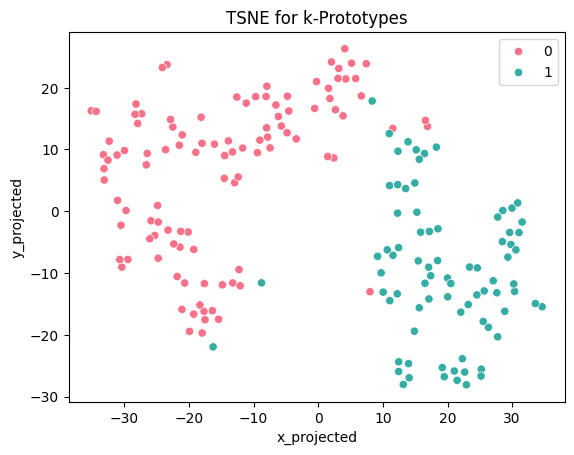

In [20]:
sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", 2), data=df_combo)
plt.legend(bbox_to_anchor=(1,1))
plt.title('TSNE for k-Prototypes')
plt.show()

Looking at the TSNE plot, the clusters are generally accurate. The 2 clusterest are clearly separated except the area in the top of the graph, where there is not as clear of a distinction of the clusters. Some data points, about 7, are outliers to the other data points in their clusters.

### Additional Cluster Exploration

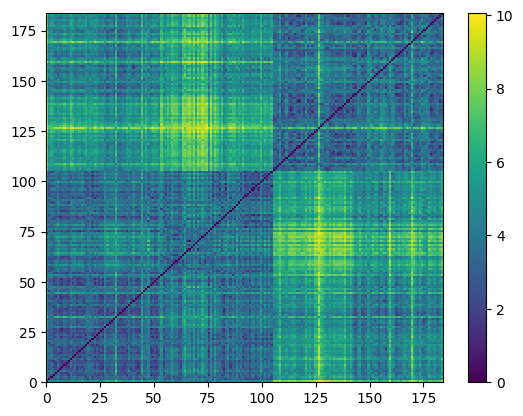

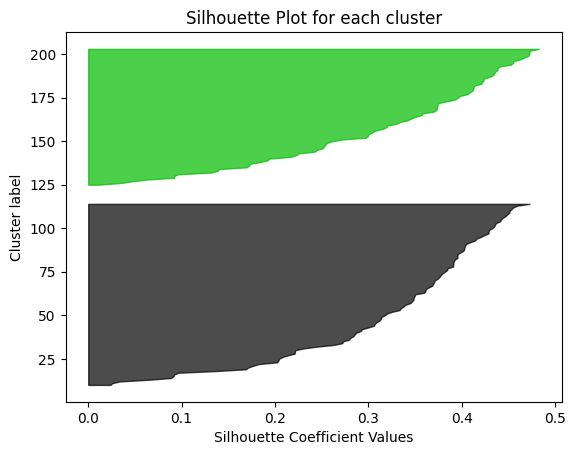

0.3221802190408837


In [21]:
from gower import gower_matrix
from sklearn.metrics import silhouette_samples, silhouette_score

# cluster distances
df_sort = df_combo.sort_values(by=['predicted_cluster'])
df_sort = df_sort.iloc[:, :12]
dist_mat = squareform(pdist(df_sort))

#Then visualize the distance matrix with a heat map.
plt.pcolormesh(dist_mat)
plt.colorbar()
N = len(df_sort)
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

# silhouette scores
silhouette_avg = silhouette_score(proto_df.select_dtypes(include='number'), fit_clusters)
silhouette_values = silhouette_samples(proto_df.select_dtypes(include='number'), fit_clusters)

fig, ax = plt.subplots()
y_lower = 10
for i in range(kp.n_clusters):
    cluster_silhouette_values = silhouette_values[fit_clusters == i]
    cluster_silhouette_values.sort()
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.nipy_spectral(float(i) / kp.n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    y_lower = y_upper + 10

ax.set_title("Silhouette Plot for each cluster")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster label")
plt.show()

print(silhouette_score(proto_df.select_dtypes(include='number'), fit_clusters))

Looking at the sorted distance matrix, the clusters have about the same cohesion, since the avearge distance of the intra-cluster distances shown on three blocks on the block diagonal are about the same. The clusters are clearly separated.

Looking at the silhouette plot for each cluster, none of the clusters have good silhouette scores. None of the clusters do reach 0.5, which is not ideal. Also, looking at the average silhouette score which is 0.3221802190408837, the separation and cohesion of the cluster is not very good, since the value is closer to 0 than 1.

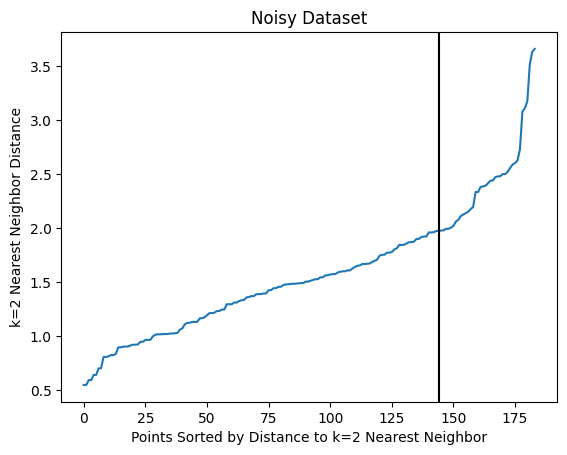

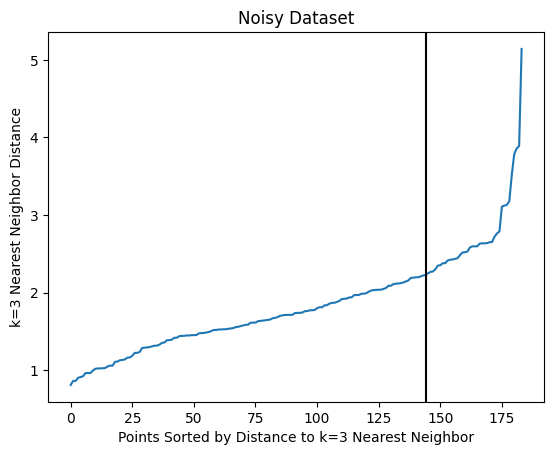

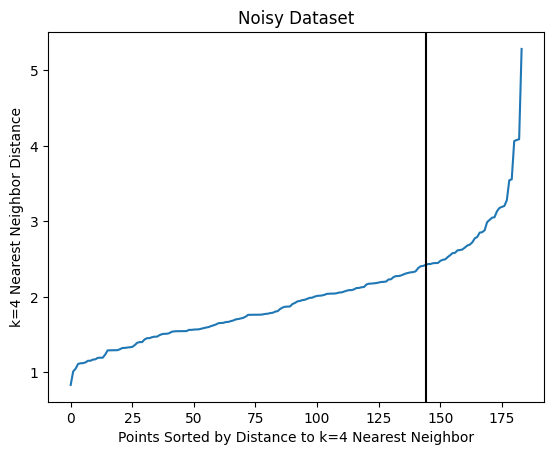

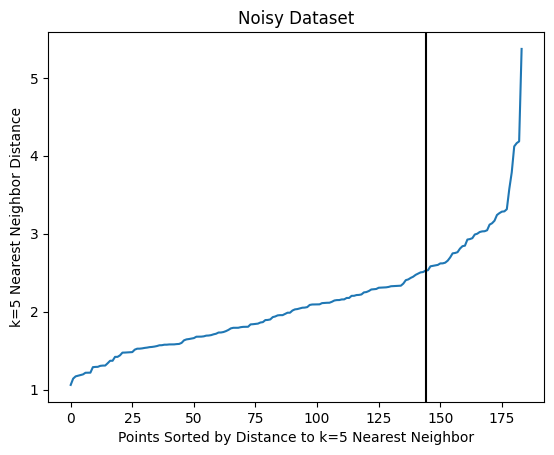

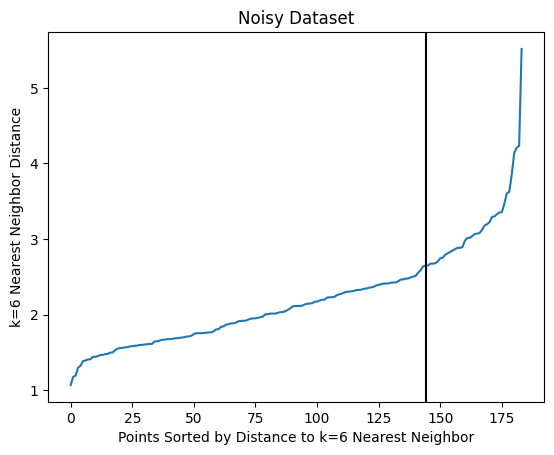

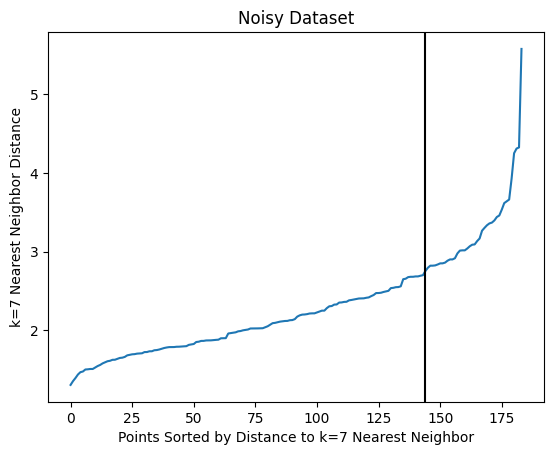

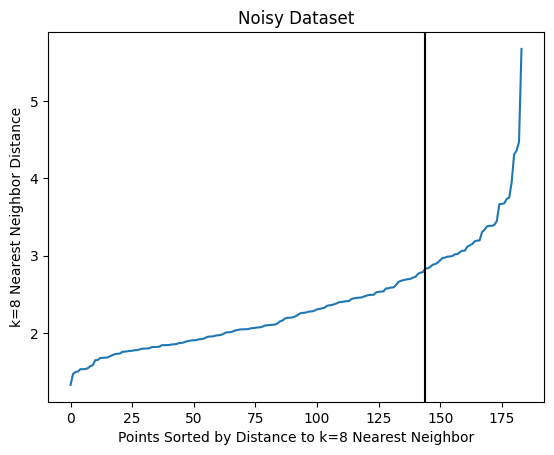

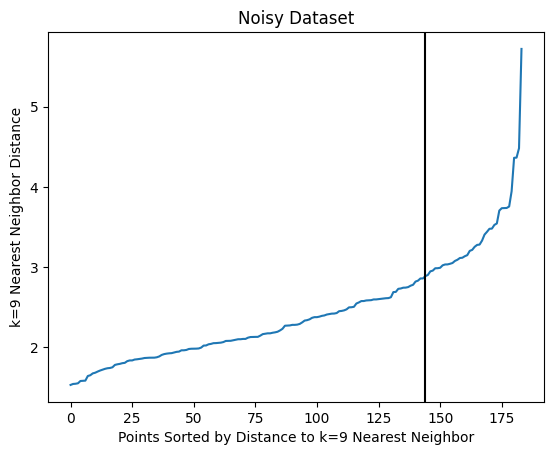

In [22]:
# cluster sparseness
from sklearn.neighbors import NearestNeighbors

for k in range(2,10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(proto_df.select_dtypes(include='number'))
    distances, indices = nbrs.kneighbors(proto_df.select_dtypes(include='number'))

    plt.plot(np.sort(distances.T[k-1]))
    plt.axvline(x=len(proto_df.select_dtypes(include='number'))-40, color='black')
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('Noisy Dataset')
    plt.show()

In all the KNN plots, there is a gradual increase as the number of data points increases. There is a dramatic jump in nearest neighbot distances when the number of observations is 175, indicating some noisy data points exist in the current dataset after standarization. There is evidence of cluster sparseness because of the steady increase of distances in the plots.


### Shortcommings
There is some reason to believe that the similiarty matrix or silhouette plot are not the best techniques to measure cohesion and separation of the clusters. The K-prototype clusters do not have a very spherical shape and do not always have the clearest separation.

### Clustering Meaningfulness to do after finding cluster distances
From additional cluster exploration, we conclud that the clusters are well-separated from each other, but they have low silhouette scores, which is not ideal. There is evidence of noise which may be affecting the cohesion of the clusters. The clustering is not highly meaningiful. Another model may be better at clustering our dataset, or more preprocessing of our data will improve clustering. The meaningfulness of the clustering in respect to our research goals will be discussed more in detail in the section below.

### Describing Each of the Clusters

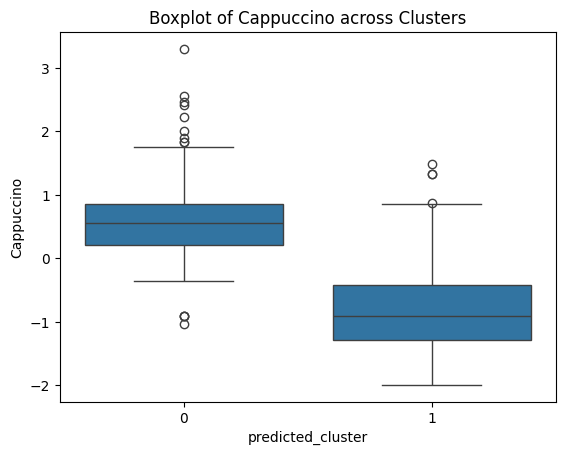

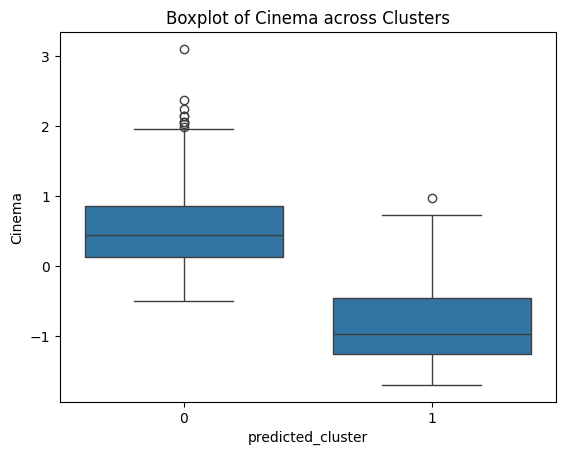

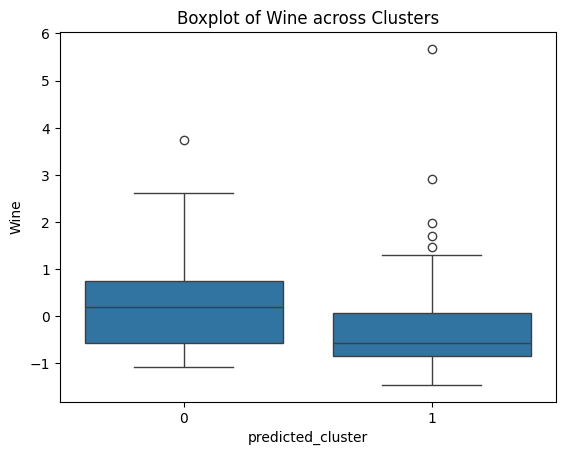

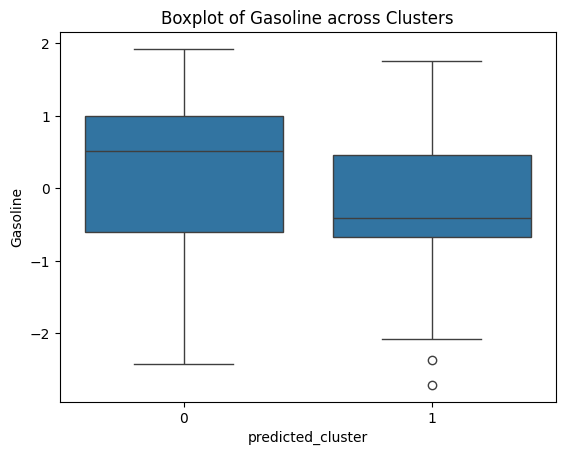

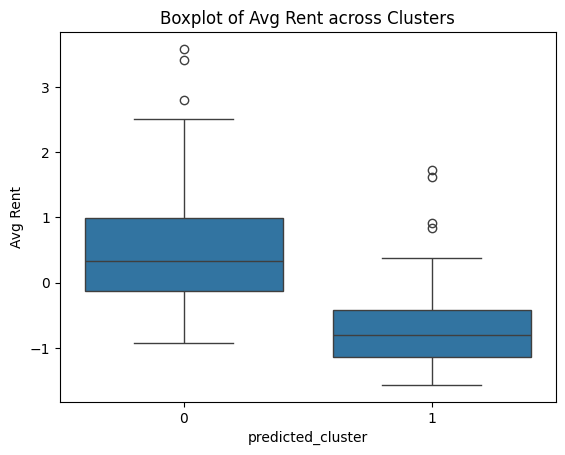

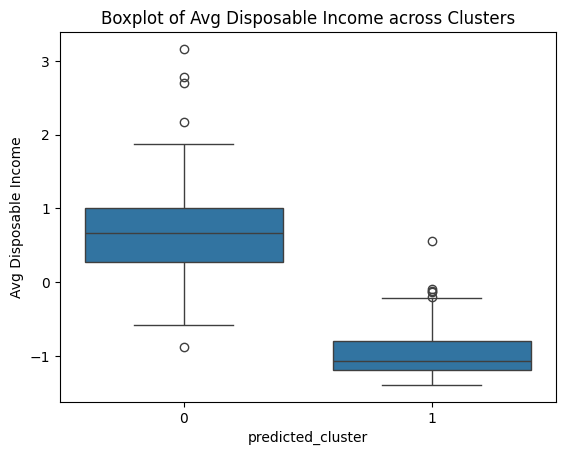

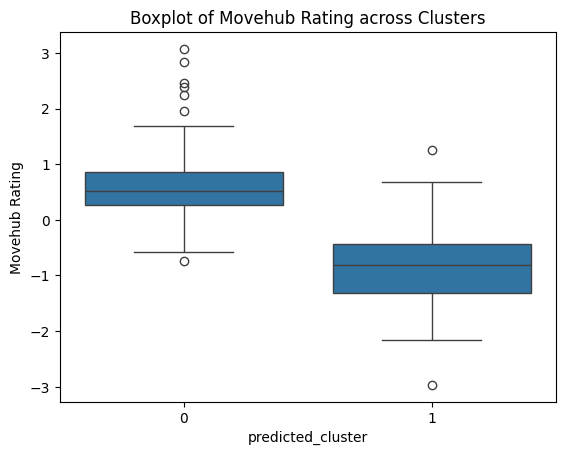

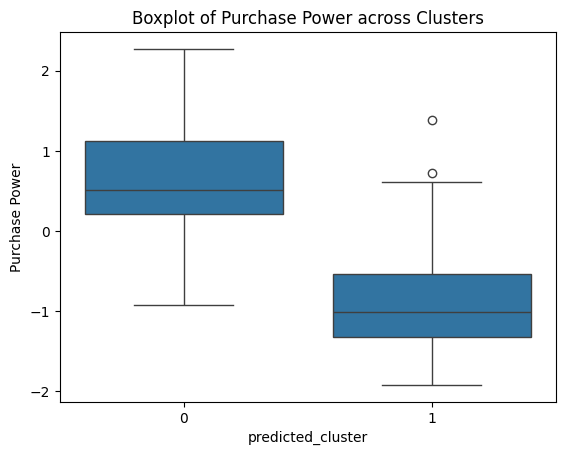

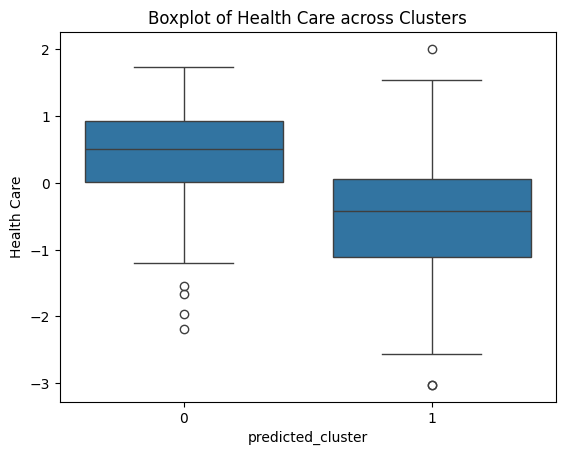

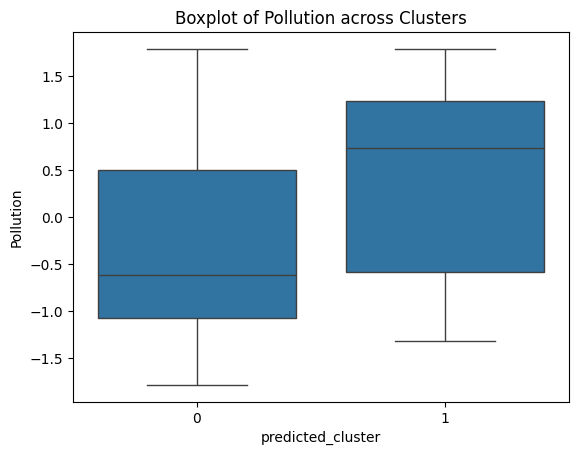

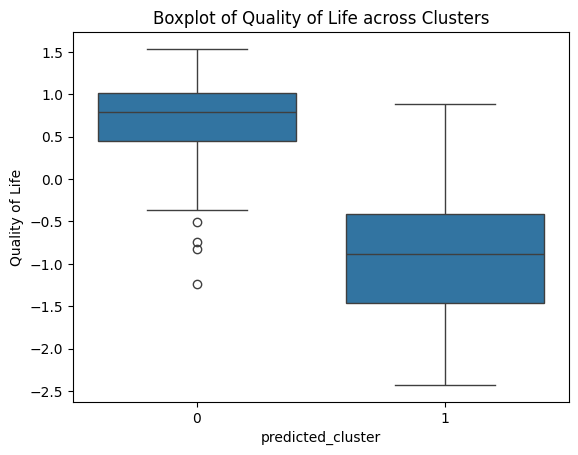

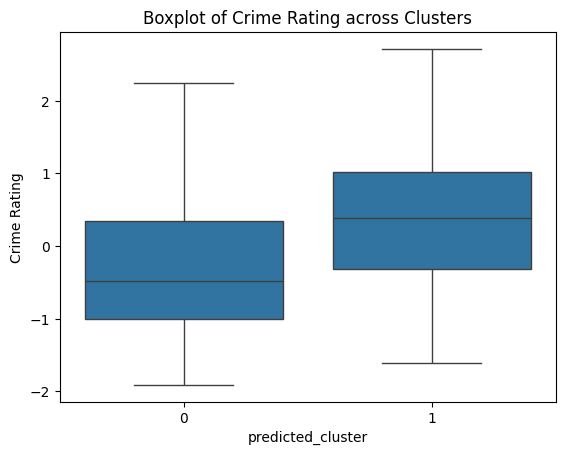

In [23]:
df_cols = df_combo.iloc[:, :-3].select_dtypes(include='number').columns
for i in df_cols:
    sns.boxplot(x='predicted_cluster', y=i, data=df_combo)
    plt.title(f'Boxplot of {i} across Clusters')
    plt.show()

The biggest defining featuers of the clusters is Quality of Life, Purchase Power, and Avg Disposable Income. Health Care, Gasoline, and Wine are the least defining features for the clusters. The two clusters are relatively distinct from one another, cluster 0 containing higher quality of living cities.

## 10. Clustering Algorithm #2: Gaussian Mixture Model

### Parameter Selection
We would like to use AIC and BIC scores to select a number of clusters that best produce the clustering results.

For AIC score, it's best to use AIC when $\frac{n}{n_p}>40$.

According to previous analysis, we know that n=184, which means that $n_{p}$ should be less than 4.6.

Because in our Gaussian mixture models, the number of parameters that we need in our model is:
$n_p = k(1 + d+ d^2)$ (where d=15=number of attributes), then $k<0.016$. Thus using AIC is not ideal for assessing whether any value of $k$ yields a parsimonious model 

(184, 14)


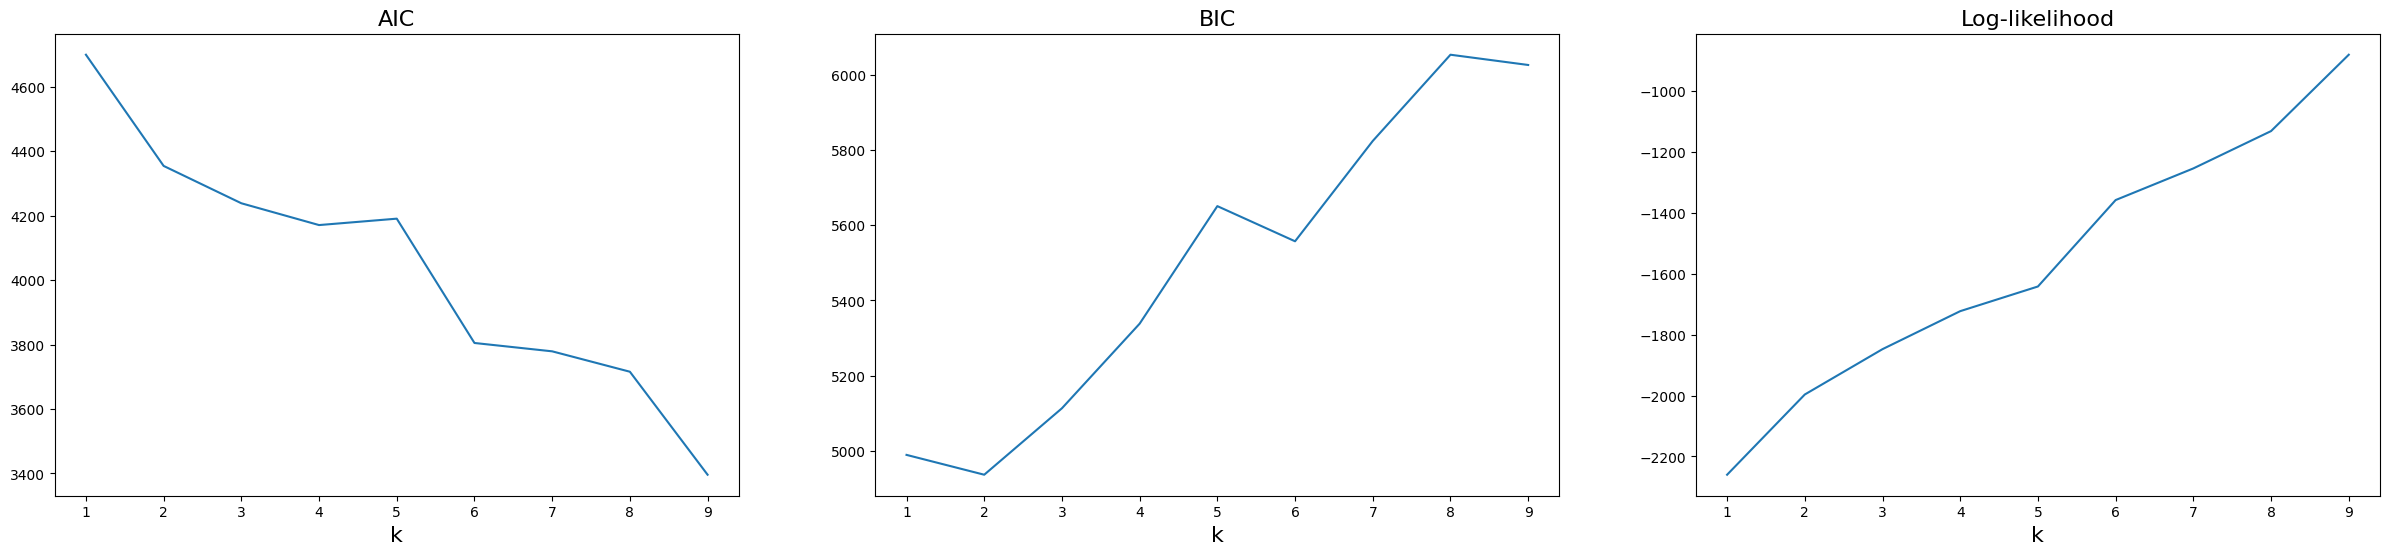

In [24]:
print(np.shape(df_scaled))

from sklearn.mixture import GaussianMixture
aics = []
bics = []
log_likelihoods = []

for k in range(1, 10):
    #Fit the GMM model
    gm = GaussianMixture(n_components=k, random_state=100)
    gm.fit(df_scaled.select_dtypes(include='number'))
    
    #Calculate the AIC, BIC, and log-likelihood for this model
    aics.append(gm.aic(df_scaled.select_dtypes(include='number')))
    bics.append(gm.bic(df_scaled.select_dtypes(include='number')))
    log_likelihoods.append(gm.score(df_scaled.select_dtypes(include='number')) * len(df_scaled.select_dtypes(include='number')))


#Plot these values
fig, ax = plt.subplots(1, 3, figsize=(30, 6))

#AIC
ax[0].plot(range(1, 10), aics)
ax[0].set_xticks(range(1,10))
ax[0].set_xlabel('k', fontsize=16)
ax[0].set_title('AIC', fontsize=16)

#BIC
ax[1].plot(range(1, 10), bics)
ax[1].set_xticks(range(1, 10))
ax[1].set_xlabel('k', fontsize=16)
ax[1].set_title('BIC', fontsize=16)

#Log-likelihood
ax[2].plot(range(1, 10), log_likelihoods)
ax[2].set_xticks(range(1, 10))
ax[2].set_xlabel('k', fontsize=16)
ax[2].set_title('Log-likelihood', fontsize=16)

plt.show()

### Conclusion of Parameter Selection

The BIC score is suggesting that a Gaussian mixture model clustering with k=2 clusters will yield a parsimonious model, while the AIC score is suggesting that a Gaussian mixture model clustering with k=9 clusters will yield a parsimonious model. 

We will proceed with using four clusters as the AIC evaluation criteria are not met based on previous analysis. 

### Training the GMM model on the data

In [25]:
# Train the model
gm = GaussianMixture(n_components=2, random_state=1001)
gm.fit(df_scaled.select_dtypes(include='number'))
Y_pred = gm.fit_predict(df_scaled.select_dtypes(include='number'))
W=gm.predict_proba(df_scaled.select_dtypes(include='number'))

### Results Presentation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


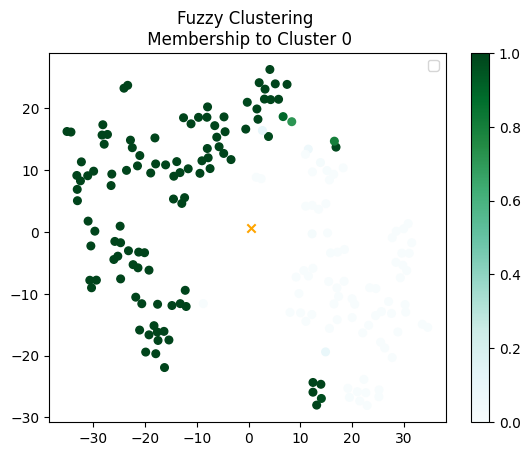

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


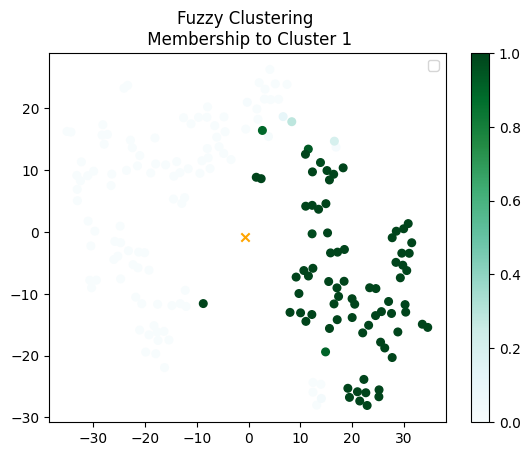

In [26]:
#Plot the cluster membership scores for each cluster.
for i in range(0,2):
    #Create a column with cluster i membership scores
    df_combo['Cluster %s Membership Score'%str(i)]=W[:,i]

    #Plot the points, color coded by the membership score.
    points = plt.scatter(df_combo["x_projected"], df_combo["y_projected"],
                 c=df_combo['Cluster %s Membership Score'%str(i)], s=30, cmap="BuGn")
    plt.colorbar(points)

    #Plots the centroids as well.
    plt.scatter(gm.means_[i][0],gm.means_[i][1], marker="x", color='orange')        
    plt.title('Fuzzy Clustering \n Membership to Cluster %s'%str(i))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### Additional Cluster Exploration

In [27]:
cluster_columns=['Cluster %s Membership Score'%(str(i)) for i in range(0,2)]
df_membership=pd.DataFrame(W, columns=cluster_columns)
df_membership.round(4)

Cluster 0 Membership Score  Cluster 1 Membership Score
0                        1.0000                      0.0000
1                        1.0000                      0.0000
2                        1.0000                      0.0000
3                        1.0000                      0.0000
4                        1.0000                      0.0000
..                          ...                         ...
179                      0.0000                      1.0000
180                      0.0000                      1.0000
181                      0.0000                      1.0000
182                      0.0000                      1.0000
183                      0.0002                      0.9998

[184 rows x 2 columns]

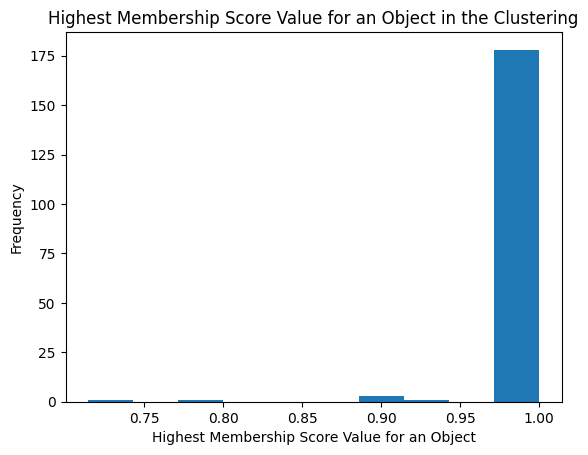

In [28]:
highest_membership_scores=df_membership.T.max()
plt.hist(highest_membership_scores)
plt.title('Highest Membership Score Value for an Object in the Clustering')
plt.xlabel('Highest Membership Score Value for an Object')
plt.ylabel('Frequency')
plt.show()

### Highest Membership Score Interpretation

According to the Highest Membershio Score Value plot, the cluster assignment of most observations in the GMM model is a hard assignment as almost all the observations have the highest membership score as 1. Only fewer than 10 observations have a score between 0.75 and 1.

### Dunn's Partitioning Coefficient

In [29]:
#Get the cluster membership scores
m = W.shape[0]

W_C = 1*np.sum(W**2)/m

P_c = (W_C - 1/4)/(1-1/4)
print(P_c)

0.9876231079128798


### Interpretation
Because the Dunn's partitioning coefficient is close to 1, the membership matrix is almost a hard assignment.

### Cluster Meaningfulness

The GMM clustering algorithm is a meaningful algorithm in clustering data. Our original research goal is identifying underlying patterns of cities based on information such as cost of living and quality of life. The plots above demonstrate that we can separate four distinct clusters with each cluster representing cities with similar features.  

### Description of Clusters

In [30]:
gmm_partition=[df_membership.T[i].argmax() for i in range(0,len(df_membership))]
df_combo['gmm_clustering']=gmm_partition
df_combo.tail(5)

Cappuccino    Cinema      Wine  Gasoline  Avg Rent  \
179   -0.728815 -1.167440  0.090753 -2.365288 -1.069543   
180   -1.281487 -1.167440 -0.567815 -0.982562 -1.443248   
181   -0.978833 -1.167440 -0.143602 -1.011369 -1.429648   
182   -1.992066 -1.525589 -0.843701 -0.838528 -0.696083   
183   -1.399917 -1.547516 -0.294895 -0.492847 -1.431172   

     Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
179              -1.348090       -1.753862       -1.651958    -0.635990   
180              -1.374306       -1.771934       -1.517957    -0.964581   
181              -1.381618       -1.845731       -1.624962    -1.140588   
182              -1.391218       -2.966238       -1.922905    -0.140091   
183              -1.395111       -0.481243       -0.479327    -2.318431   

     Pollution  Quality of Life  Crime Rating         City   Country  \
179   1.549729        -1.886194      0.436565        Cairo     Egypt   
180   0.910685        -1.829770      2.016629      Karachi  Pakistan   
181  -0.600134        -1.377477      0.632604       Lahore  Pakistan   
182   1.527693        -1.382442     -0.971579  Addis Ababa  Ethiopia   
183   0.515970        -0.474245     -1.534960       Indore     India   

     x_projected  y_projected  predicted_cluster  Cluster 0 Membership Score  \
179    20.024424   -13.854163                  1                2.748948e-18   
180    20.516022   -11.696302                  1                5.485535e-12   
181    23.402016    -9.031300                  1                1.012594e-13   
182    27.758432   -20.329016                  1                2.296634e-16   
183    28.853952   -16.186304                  1                2.251887e-04   

     Cluster 1 Membership Score  gmm_clustering  
179                    1.000000               1  
180                    1.000000               1  
181                    1.000000               1  
182                    1.000000               1  
183                    0.999775               1

### Cluster-sorted similar matrix

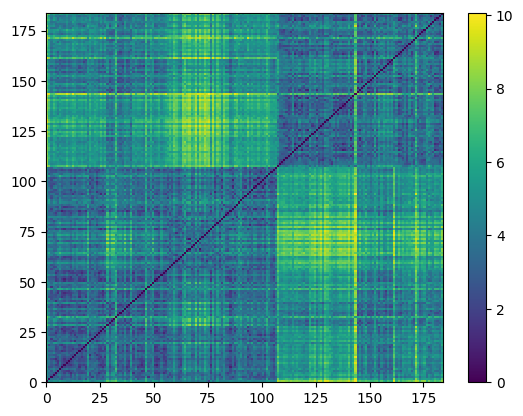

In [31]:
#Create a distance matrix

df_sort=df_combo.sort_values(by=['gmm_clustering'])

df_sort=df_sort.iloc[:, :12]

dist_mat = squareform(pdist(df_sort))

#Then visualize the distance matrix with a heat map.
plt.pcolormesh(dist_mat)
plt.colorbar()
N = len(df_sort)
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

In [32]:
df_combo['gmm_clustering'].value_counts().sort_index().cumsum()

gmm_clustering
0    107
1    184
Name: count, dtype: int64

In [33]:
df_sort.head(5)

Cappuccino    Cinema      Wine  Gasoline  Avg Rent  Avg Disposable Income  \
0     1.547668  2.238629  0.408171  0.889879  1.041162               3.163401   
78    0.718660  0.926635 -0.303794  0.169710  0.078921               0.291836   
77    0.547595  0.433266  0.752287 -0.521653  0.008496               0.294882   
76    0.758136  0.550213  1.698608 -0.348813  1.262023               0.294882   
75    0.679183  0.550213  0.280610  1.005107  0.681778               0.334942   

    Movehub Rating  Purchase Power  Health Care  Pollution  Quality of Life  \
0         1.149818        2.219344    -0.008922   1.606172         0.639787   
78        0.701013        1.936126     1.644074  -1.781187         0.946281   
77        0.280823        0.361001     0.913276   0.883623         0.985552   
76        0.454019        0.122941     1.187660  -1.066757         0.580204   
75        0.205520        0.234363     0.014501  -1.337374         0.589231   

    Crime Rating  
0      -0.383461  
78      1.128577  
77      0.043249  
76     -0.724829  
75     -1.084131

* <u>Cluster Separation</u>: 
  - cluster 0 is far away from cluster 1
* <u>Cluster Cohesion</u>: 
  - cohesion is low for both clusters  

For n_clusters = 2 The average silhouette_score is : 0.29580392337465006


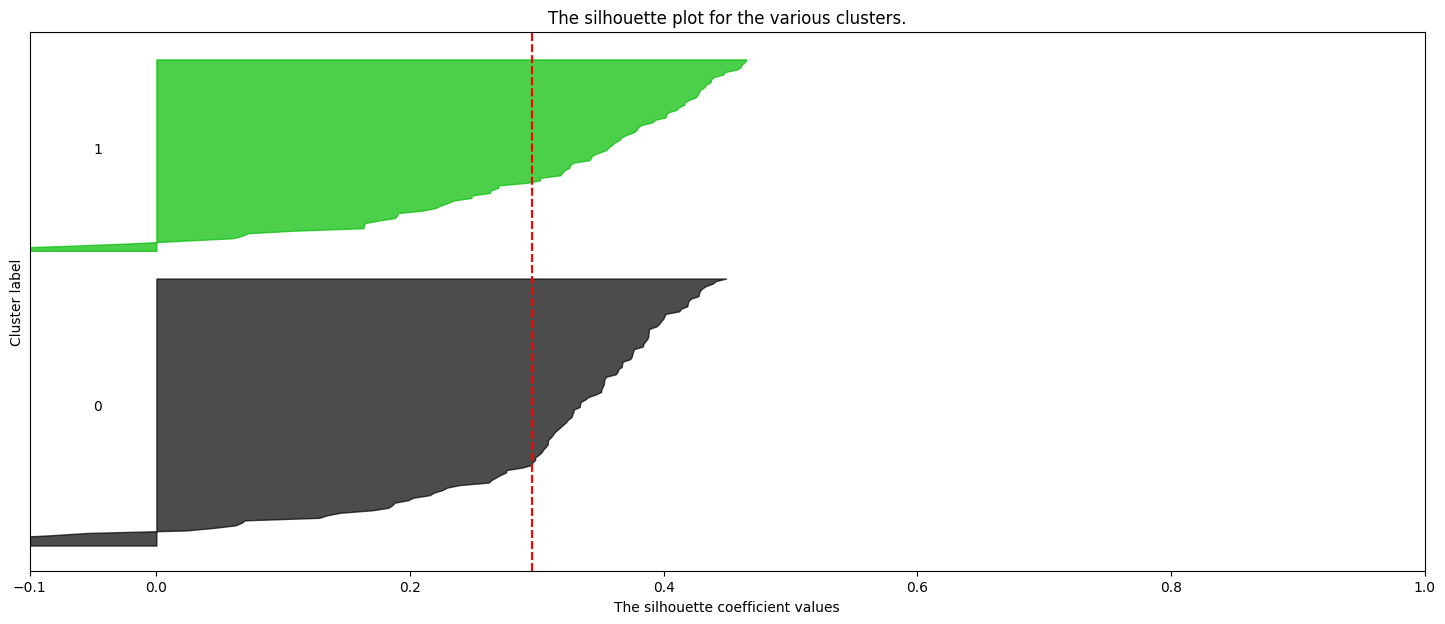

In [34]:
def show_silhouette_plots(X,cluster_labels):
    
    # This package allows us to use "color maps" in our visualizations
    import matplotlib.cm as cm
    
    #How many clusters in your clustering?
    n_clusters=len(np.unique(cluster_labels))    

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient fcan range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.show()
    
    return

show_silhouette_plots(df_scaled.select_dtypes(include='number'), df_combo['gmm_clustering'])

<u>Evaluating the Cohesion and Separation of Each of the Clusters in the Clustering</u>
* Cluster 0 has some points on the negative side of the x-axis, which means that the points in cluster 0 are not very cohesive.  
* Cluster 1 also has some points on the negative side of the x-axis, which means that the points in cluster 1 are not very cohesive. But, cluster 0 is better than cluster 1 in terms of cohesion.  

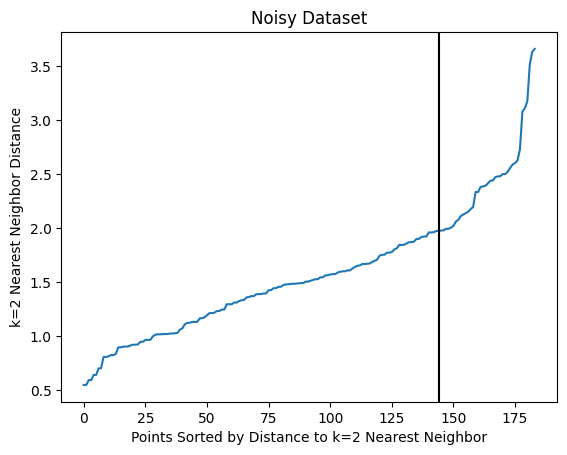

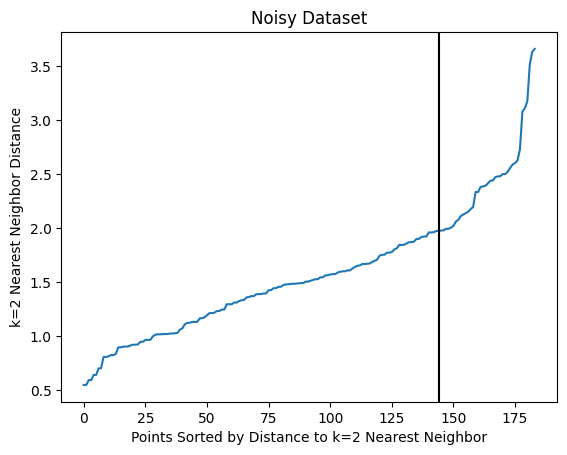

In [35]:
for cluster in df_combo['gmm_clustering'].unique():
    df.an = df_combo[df_combo['gmm_clustering']==cluster]
    k = 2
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(df_scaled.select_dtypes(include='number'))
    distances, indices = nbrs.kneighbors(df_scaled.select_dtypes(include='number'))

    plt.plot(np.sort(distances.T[k-1]))
    plt.axvline(x=len(df_scaled.select_dtypes(include='number'))-40, color='black')
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('Noisy Dataset')
    plt.show()

About 35 points in the dataset are outliers. The outliers are not very well separated from the rest of the data points.

##### Cluster Sparseness

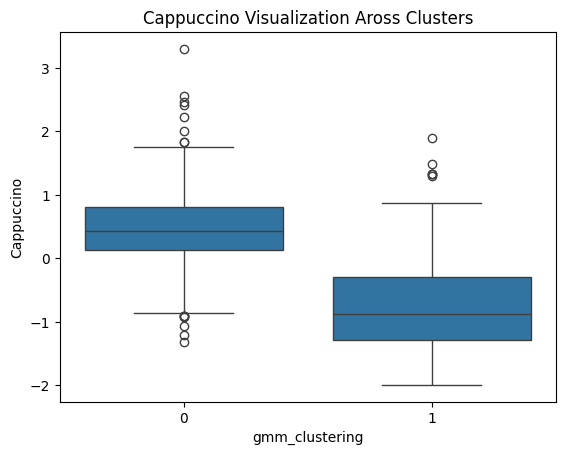

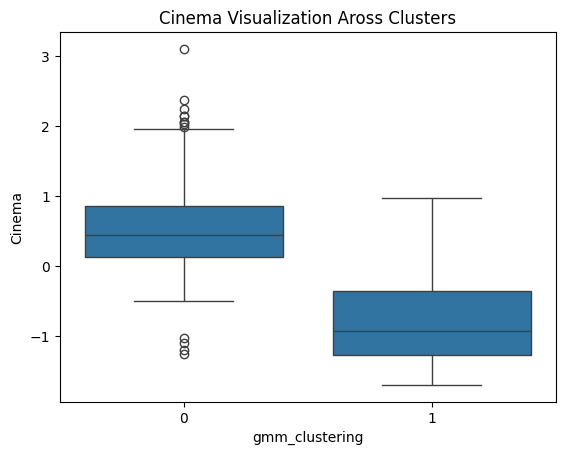

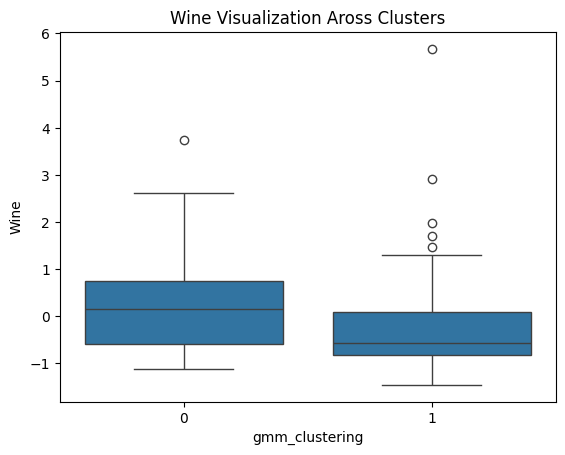

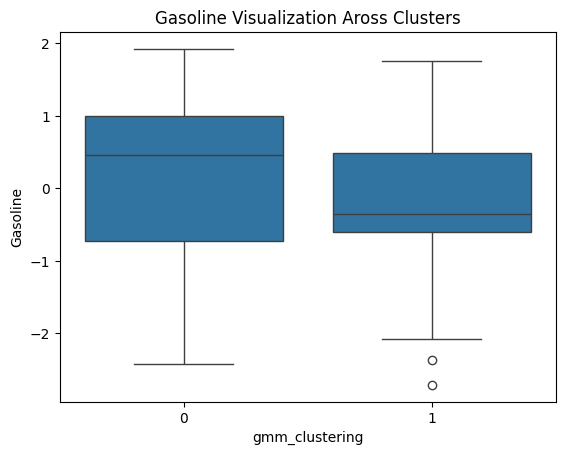

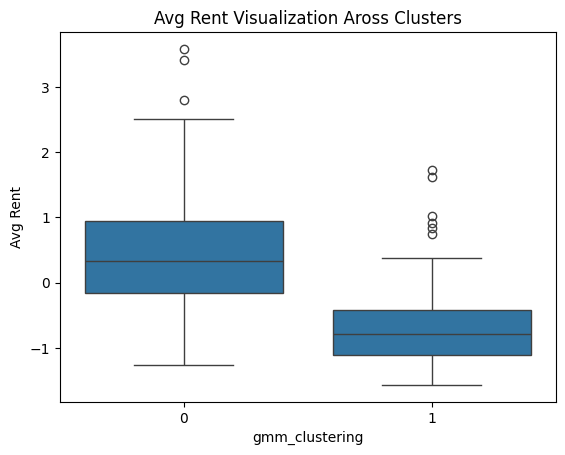

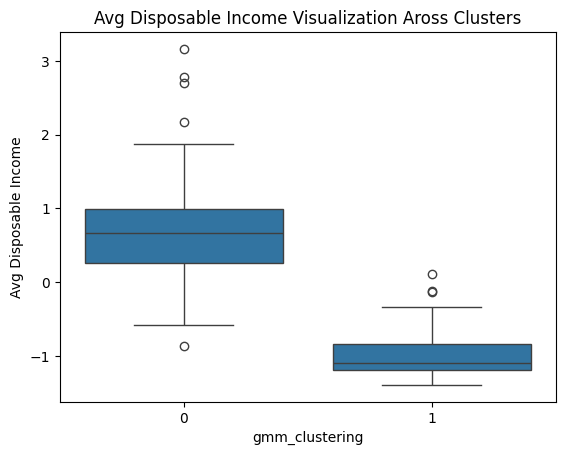

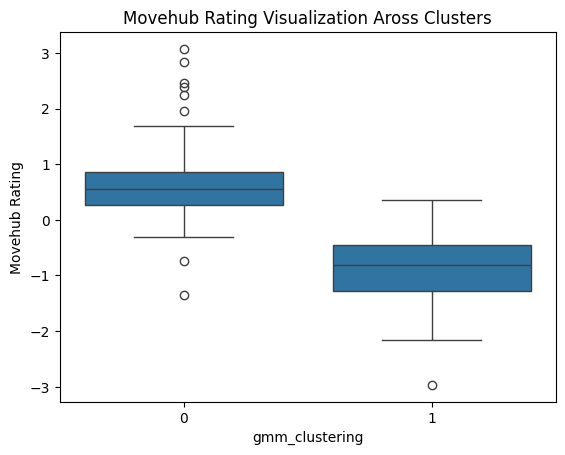

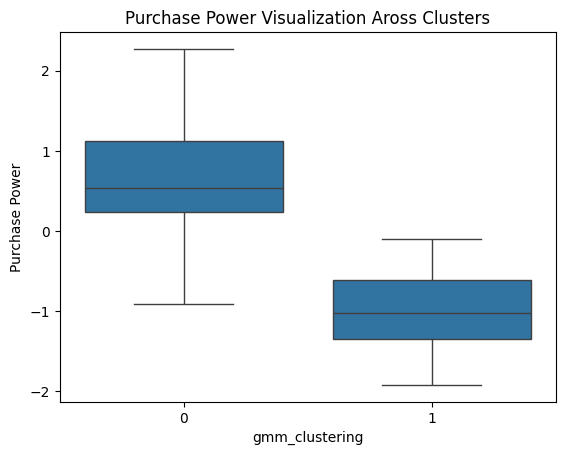

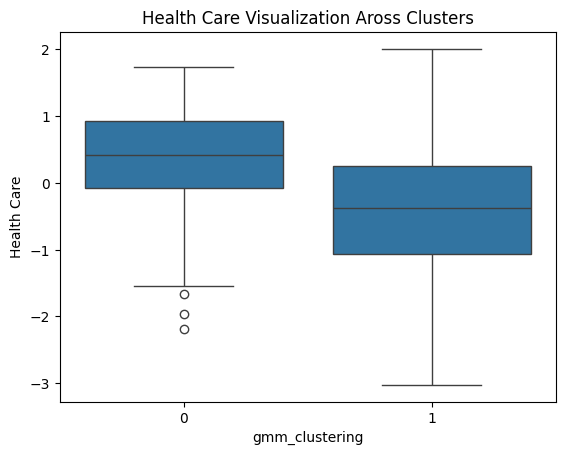

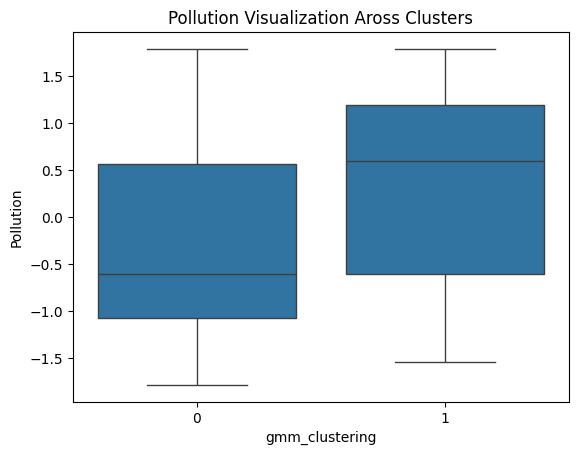

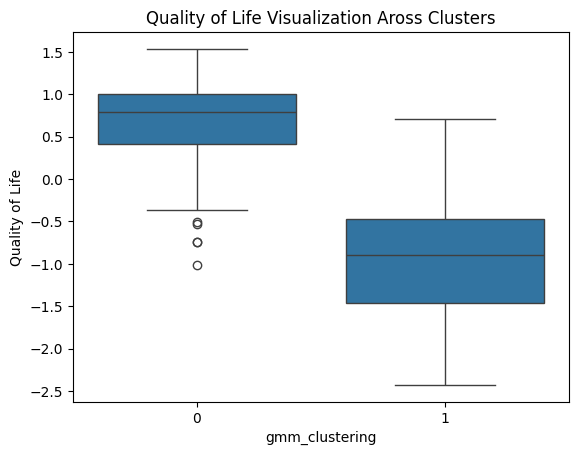

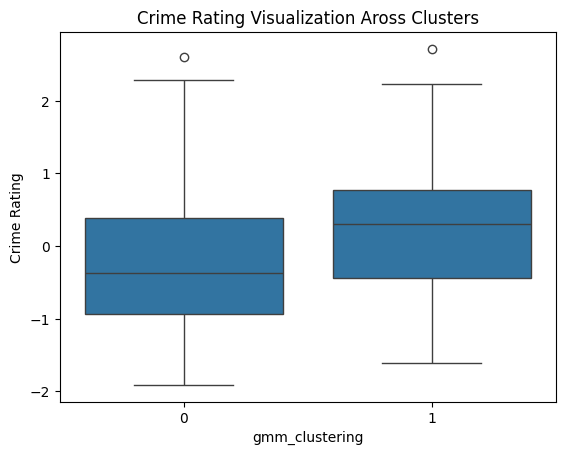

In [36]:
for column in df_combo.columns[:12]:
    plt.figure()
    sns.boxplot(data=df_combo, x='gmm_clustering', y=df_combo[column])
    plt.title(f'{column} Visualization Aross Clusters')

### Description

Based on the plots of each numerical variable above, we come up with the following conclusions:

1. In general, most of the numerical variables are associated with clustering results as we do see some variation across two clusters for each metric. 
2. The variables 'Avg Disposable Income', 'Movehub Rating', 'Qualify of life' and 'Purchase Power' have the greatest variation across two clusters in the plot.
3. The distributions of the variable 'Health Care', 'Pollution', 'Gasoline' and 'Crime Rating' are fairly consistent across four clusters. 

## 11. Discussion

In [37]:
#Adjusted rand score for GMM
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(df_combo['gmm_clustering'], df_combo['predicted_cluster'])

0.7547349153361781

### Clustering Comparison
The result of the two cluster algorithms are different but their result is very similar, even when the Gaussian Mixture model identified 4 clusters while the K-prototype only identified 3, it still achieved an adjusted rand score of 0.864. The subtle differences between the two assignments might be due to the fact the difference in the number of clusters identified. Additional to that, K-prototype is a hard cluster assignment algorithm while Gaussian Mixture Model is a fuzzy clustering algorithm. 

### Clustering Insight
K-prototype does not reveal any more insights that Gaussian Mixture Model have not already revealed. Additionally, the fuzzy assignment assigned the cities a probability score that a city belongs to each cluster. Given that the Gaussian Mixture Model returned a very hard assignment, it further boosts our confidence on the validity of its assignment. Gaussian Mixture Model might be more suitable for the ambiguity definition of a good quality of life. 

### Clustering Meaningfulness
Since the adjusted rand score identified that two algorithms provided a very similar result, Gaussian Mixture Model may have provided a meaningful clustering because it provided the clustering membership score which gave insight on how the clustering assignment was formed. Since quality of life is multifactored with a subjective definition, fuzzy cluster assignment may help in selecting a group of cities that match the client's definition of quality of life. 

### Clustering Usefulness
They both provided useful insight because they both successfully clustered the dataset into separate and similar clusters. Together, they validated each other’s result with their assignment similarity which also boosts our confidence on our cluster assignment. Going forward, we can be more confident about our result when creating recommendations for our stakeholders and individuals who might be interested in this dataset. Depending on the client's need, we might lean on using Gaussian Mixture Model

## 12. Conclusion

### Summarize  
For this project we defined our research goal as providing insightful informations about the different cities and the associations between the cities and the attributes. We then did data exploration and data cleaning - cleaned outliers and standardized the data. We used two algorithms to cluster the data: K-Prototype and Gaussian Mixture Model. The algorithm clustered the dataset into two clusters - low and high quality of life. One of the cluster generally has lower quality of life, healthcare, movehub rating and higher crime rating. The resulting cluster provides a simplification of our data.   
### Recommendation  
Our research motivation is to provide meaningful insight on the different attributes and their association with the cities. The conclusion was that the quality of life and average disposable income are the most important factors in determining the clusters of preferable place or not. For people that are looking for a new place to live and international travelers, they can use the clustering results to determine which cities are preferable for them. It would save their time and resources having to research each individual environment and also ensures a more targeted and efficient strategy. The Gaussian Mixture Model algorithm could give a more informative clustering result. The high probability in the membership score of the cluster that identifies a high quality of life can provide assurance that the location offers a good standard of living. For individuals, the clustering algorithm is able to create quick recommendations based on their preferences by looking at the difference in qualities between each cluster. This method simplifies the decision-making process for individuals looking for places that meet their specific needs but also enhances the accuracy and relevance of the recommendations provided. 
### Shortcomings  
Despite the high confidence in our clustering results in our findings, given that both K-Prototype and Gaussian Mixture Model came to the same conclusion in our analysis, there are some flaws that we like to adjust going forward. 

K-Prototype is a non-deterministic algorithm which means that the algorithm might settle on different clustering results depending on where the initial centroid was placed. Ideally, the K-Prototype algorithm needed to be run multiple times with different random states. The results will be compared, and the best result would be used to make a conclusion. 

Additionally, quality of life is multifactorial and subjective. Different people generally have their own definition for their ideal standard of life. This analysis and clustering only identified two clusterings, one group generally has a lower standard of living than the other. While this provides a significant and time-saving simplification of our data by clustering the observations into two clusters, it's important to recognize that individual perceptions and aspirations regarding their quality of life can vary significantly. Therefore, going forward, a hierarchical algorithm might be better suited for a more intricate dive for appealing to individualized definition of the standard of life. Hierarchical algorithms provide different cut-off points to cluster cities, and this flexibility allows the clients to choose the environment that has the qualities that they wish for. 

It’s important to recognize that while our analysis provided the necessary simplification of our dataset, it still has its shortcomings. Non-deterministic nature of K-Prototype highlighted the importance of running multiple iterations. The subjective and multifactorial definitions of the quality of life opens for a consideration for a more flexible clustering algorithm like hierarchical algorithms. Going forward, it is essential to take these flaws into account to enhance the depth and precision of our analysis, ultimately providing a more tailored and valuable service to our clients in the pursuit of an improved quality of life. 

### Future Work  
After doing the analysis, we found that we could change the methods a little to see if the results would be different. For example, we could have use the original dataset and did not standardize the dataset. Another thing we could do is to use different clustering algorithms such as hierarchical clustering and DBSCAN.



## References

Blitzer. “Movehub City Rankings.” Kaggle, 24 Mar. 2017, www.kaggle.com/datasets/blitzr/movehub-city-rankings?select=movehubqualityoflife.csv. Accessed 9 Dec. 2023. 
 
Ruberts, Anton. “K-Prototypes - Customer Clustering with Mixed Data Types.” Well Enough, 16 May 2020, antonsruberts.github.io/kproto-audience/. Accessed 9 Dec. 2023. 

“Gaussian Mixture Model.” Brilliant Math &amp; Science Wiki, brilliant.org/wiki/gaussian-mixture-model/. Accessed 9 Dec. 2023. 